## Table des matières

 - [Vérification des données](#Intro)
 - [Mission 1](#chapitre_1)
     - [Années des données utilisées](#chapitre_1_1)
     - [Nombre de pays présents](#chapitre_1_2)
     - [Population couverte par l'analyse (en pourcentage de la population totale)](#chapitre_1_3)
 - [Mission 2](#chapitre_2)
     - [Diversité des pays en terme de distribution de revenus](#chapitre_2_1)
     - [Courbe de Lorenz de chacun des pays choisis](#chapitre_2_2)
     - [Évolution de l'indice de Gini au fil des ans](#chapitre_2_3)
 - [Mission 3](#chapitre_3)
     - [Question 1](#chapitre_3_1)
     - [Question 2](#chapitre_3_2)
     - [Question 3](#chapitre_3_3)
     - [Question 4](#chapitre_3_4)
     - [Question 5](#chapitre_3_5)
     - [Question 6](#chapitre_3_6)
     - [Question 7](#chapitre_3_7)
     - [Question 8](#chapitre_3_8)
     - [Question 9](#chapitre_3_9)
     - [Question 10](#chapitre_3_10)
     - [Question 11](#chapitre_3_11)
 - [Mission 4](#chapitre_4)
     - [Question 1](#chapitre_4_1)
     - [Question 2](#chapitre_4_2)
     - [Question 3](#chapitre_4_3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t, shapiro
from scipy.stats import ks_2samp
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data-projet7.csv', decimal=",")

data.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0


<a id="Intro"></a>
## <span style="color: #030aa4">Vérification des données</span>

In [3]:
def data_check (df):
    df = data
    print("Vérification de la table 'data':")
    print(" ")
    print(df.dtypes)
    print(" ")
    print(df.isnull().sum())
    print(" ")
    print(df.describe())
    print(" ")
    if df.nb_quantiles.unique() == 100 :
        print ("La colonne 'nb_quantiles' indique que chaque pays doit avoir 100 quantiles.")
    else :
        print("La colonne 'nb_quantiles' indique qu'il n'y a pas toujours 100 quantiles par pays.")
    print(" ")
    if len(data)/len(data.country.unique()) == 100 :
        print("Il ne manque aucun quantile.")
    else :
        nombreQuantilesManquants = (len(data.country.unique())*100)- len(data)
        quantileManquant = data.groupby(['country'],as_index=False)['quantile'].count()
        quantileManquant = quantileManquant[quantileManquant['quantile'] != 100]
        paysQuantileManquant = quantileManquant.country.unique()
        print("Il y a", nombreQuantilesManquants ,"quantile manquant dans la colonne 'quantile' pour le pays", paysQuantileManquant[0],".")
        print(" ")
        NumeroQuantileManquant = df[df.country== paysQuantileManquant[0]]['quantile'].unique()
        def missing_elements(L):
            start, end = L[0], L[-1]
            return sorted(set(range(start, end + 1)).difference(L))

        print('Quantile manquant :',missing_elements(NumeroQuantileManquant)[0])
        
data_check(data)

Vérification de la table 'data':
 
country          object
year_survey       int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object
 
country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64
 
        year_survey      quantile  nb_quantiles         income        gdpppp
count  11599.000000  11599.000000       11599.0   11599.000000  1.139900e+04
mean    2007.982757     50.500819         100.0    6069.224260  5.022128e+04
std        0.909633     28.868424           0.0    9414.185972  4.000688e+05
min     2004.000000      1.000000         100.0      16.719418  3.031931e+02
25%     2008.000000     25.500000         100.0     900.685515  2.576000e+03
50%     2008.000000     51.000000         100.0    2403.244900  7.560000e+03
75%     2008.000000     75.500000         100.0    7515.420900  1.877300e+04
max     2011.000000    100.000000         100.0  17692

Les données de chaque colonne sont du bon type.

Il y a 200 valeurs manquantes dans la colonne 'gdpppp'

Il faut rajouter le quantile 41 de la Lituanie.

Le minimum et le maximum de la colonne 'gdpppp' sont très différents de la moyennne. Il faut vérifier s'il ne s'agit pas de valeurs aberrantes.

**Valeurs manquantes de la colonne 'gdpppp'**

In [4]:
missingGdpppp = data[data.gdpppp.isnull()]

missingGdpppp.groupby('country').max()

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
PSE,2009,100,100,6343.8755,NaN
XKX,2008,100,100,7609.5760,NaN


Il s'agit du gdpppp de la Palestine en 20009 et de celui du Kosovo en 2008.

Pour le Kosovo, en 2008, le gdpppp est de 7249$ (source : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?langue=fr&codePays=KSV&codeTheme=2&codeStat=NY.GDP.PCAP.PP.CD).

Pour la Palestine, en 2009, le gdpppp est de 3364$ (source : https://donnees.banquemondiale.org/indicateur/NY.GDP.PCAP.PP.CD?locations=PS chiffres pour Cisjordanie et Gaza).

In [5]:
data.loc[data.country == 'PSE','gdpppp'] = 3364
data.loc[data.country == 'XKX','gdpppp'] = 7248

In [6]:
data.isnull().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
dtype: int64

Il n'y a plus de valeurs manquantes.

**Vérification des valeurs aberrantes**

In [7]:
data.groupby('country').mean().sort_values('gdpppp',ascending=False)

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
FJI,2008.0,50.5,100.0,2098.730882,4.300332e+06
LUX,2008.0,50.5,100.0,25217.562681,7.312700e+04
NOR,2008.0,50.5,100.0,22483.375020,4.907000e+04
USA,2008.0,50.5,100.0,25503.581661,4.326100e+04
IRL,2008.0,50.5,100.0,17710.735838,3.926800e+04
...,...,...,...,...,...
MWI,2010.0,50.5,100.0,914.265402,7.288116e+02
CAF,2008.0,50.5,100.0,811.299901,6.850000e+02
NER,2007.0,50.5,100.0,650.129353,6.310000e+02


Le gdpppp le plus élevé est celui des Fidji. Il devrait être égal à 7777,693 $ selon cette source : https://donnees.banquemondiale.org/indicateur/NY.GDP.PCAP.PP.CD?locations=FJ

Le gdpppp le plus faible est celui de la République démocratique du Congo. Il devrait être égal à 603,288 $ selon cette source : https://donnees.banquemondiale.org/indicateur/NY.GDP.PCAP.PP.CD?locations=CD

In [8]:
data.loc[data.country == 'FJI','gdpppp'] = 7777.693
data.loc[data.country == 'COD','gdpppp'] = 603.288

In [9]:
data.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,11599.000000
mean,2007.982757,50.500819,100.0,6069.224260,12441.428370
std,0.909633,28.868424,0.0,9414.185972,13094.890029
min,2004.000000,1.000000,100.0,16.719418,372.000000
25%,2008.000000,25.500000,100.0,900.685515,2577.000000
50%,2008.000000,51.000000,100.0,2403.244900,7505.000000
75%,2008.000000,75.500000,100.0,7515.420900,17787.500000
max,2011.000000,100.000000,100.0,176928.550000,73127.000000


Il n'y a plus de valeurs aberrantes.

**Rajout du quantile 41 de la Lituanie**

La valeur attribuée à la colonne 'income' sera la moyenne de la somme des valeurs des quantiles 40 et 42.

In [10]:
data[data.country=='LTU'].head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6200,LTU,2008,1,100,566.3453,17571.0
6201,LTU,2008,2,100,1147.0587,17571.0
6202,LTU,2008,3,100,1490.8408,17571.0


In [11]:
dataLTU_40_42 = data[data.country == 'LTU']
dataLTU_40_42 = dataLTU_40_42[dataLTU_40_42['quantile'].isin((40,42))]
IncomeLTU41 = dataLTU_40_42.groupby('country')['income'].mean()[0]

LTU_41 = pd.DataFrame({'country' : 'LTU',
                      'year_survey' : 2008,
                      'quantile':41,
                      'nb_quantiles':100,
                      'income':IncomeLTU41,
                      'gdpppp':[17571.0]})

LTU_41

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571.0


In [12]:
data = pd.concat([data,LTU_41], ignore_index = True)
data = data.sort_values(by=['country', 'quantile'])
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0
...,...,...,...,...,...,...
11494,ZAF,2008,96,100,24553.56800,9602.0
11495,ZAF,2008,97,100,28858.03100,9602.0
11496,ZAF,2008,98,100,35750.29000,9602.0
11497,ZAF,2008,99,100,46297.31600,9602.0


Le dataframe 'data' est maintenant exploitable.

<a id="chapitre_1"></a>
## <span style="color: #030aa4">Mission 1</span>

<a id="chapitre_1_1"></a>
### <span style="color: #a40334">Années des données utilisées</span>

In [13]:
data.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004])

Les données utilisées datent des années suivantes :
- 2004
- 2006
- 2007
- 2008
- 2009
- 2010
- 2011

<a id="chapitre_1_2"></a>
### <span style="color: #a40334">Nombre de pays présents</span>

In [14]:
NombrePays = data.groupby('country').count()

print("Il y a",len(NombrePays), "pays présents.")

Il y a 116 pays présents.


<a id="chapitre_1_3"></a>
### <span style="color: #a40334">Population couverte par l'analyse (en pourcentage de la population totale)</span>

In [15]:
# Chine supprimée directement lors de la sélection des données sur le site de la FAO
pop = pd.read_csv('population.csv')
codePays = pd.read_csv('Code_Pays.csv', sep=";")

# Population totale par an :
popTotaleParAn = pop.loc[ : ,('Année','Valeur')]\
                    .groupby('Année', as_index=False).sum()\
                    .rename(columns={'Valeur':'Population_totale'})

popTotaleParAn.Population_totale *=1000

# Population couverte par analyse :

popCouverte = pd.merge(pop,codePays)
popCouverte = popCouverte.loc[ : ,('Zone','Année','Valeur','country')]

data = data.rename(columns={'year_survey':'Année'})

popCouverte = pd.merge(data,popCouverte, on=['country','Année'])

# La valeur de la population est donnée pour 1000 habitants dans la table pop
# mais la poulation est divisée par centile dans la table data
# donc on doit multiplier 'Valeur' par 10

popCouverte.Valeur *= 10
popCouverte = popCouverte.groupby('Année',as_index=False).sum()
popCouverte = pd.merge(popCouverte,popTotaleParAn)
popCouverte['Population_couverte']= (popCouverte.Valeur/popCouverte.Population_totale)*100
popCouverte = popCouverte.drop(columns=['Valeur','Population_totale','quantile','nb_quantiles','income','gdpppp'])

popCouverte

,Année,Population_couverte
0,2004,0.275923
1,2006,4.341318
2,2007,40.509316
3,2008,31.664606
4,2009,6.919476
5,2010,5.517352
6,2011,0.212297


Si les données de chaque pays ne sont basées que sur une seule année, alors chaque année regroupe de nouveaux pays.

Il serait alors possible de calculer la population couverte totale par l'étude.

**Vérification :**

In [16]:
len(data.groupby(['country','Année'], as_index=False).count())

116

En regroupant par année et par pays, nous retrouvons le même nombre de pays. Pour chaque pays, il n'y a donc qu'une seule année d'étude et le total de la population couverte ne comptera alors pas le même pays plusieurs fois.

**Population couverte totale :**

In [17]:
PopTotale = round(popCouverte['Population_couverte'].sum(),2)

print(PopTotale,"% de la population totale est couverte par l'étude.")

89.44 % de la population totale est couverte par l'étude.


Le quantile utilisé est le **centile**.

Échantillonner la population en quantiles est une bonne méthode car elle permet de constater la répartition des richesses entre groupe de même nombre.

Il est également possible de calculer des écarts et des rapports entre le dernier et le premier quantile afin de comparer la richesse des plus riches et des plus pauvres.

https://www.inegalites.fr/La-mesure-des-inegalites-qu-est-ce-qu-un-decile-A-quoi-ca-sert

https://www.youtube.com/watch?v=380mR310fA0

**L'unité de la colonne 'income', le $ppp, est le dollar en parité de pouvoir d'achat.** Cette unité permet d'uniformiser le pouvoir d'achat dans le monde entier, en prenant en compte les différences d'habitudes de consommation d'un pays à l'autre (par exemple, le pain en France, le soja au Japon...) et le coût de la vie.

Cette unité est utilisée en dollar pour une année donnée.

https://fr.wikipedia.org/wiki/Parit%C3%A9_de_pouvoir_d%27achat

De même, **le gdp ppp (Gross Domestic Product Purchasing Power Parities) est le PIB par habitant estimé sur la base de la parité du pouvoir d'achat.** Il est plus adapté que le PIB par habitant pour comparer la richesse de la population entre plusieurs états car le gdp ppp prend en compte le coût de la vie, biens et services compris, ainsi que le taux d'inflation de chaque pays.

https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)

In [18]:
data.sort_values(by='income')

,country,Année,quantile,nb_quantiles,income,gdpppp
1700,CHN,2007,1,100,16.719418,5712.000
5700,KOR,2008,1,100,17.317732,19162.000
1100,BOL,2008,1,100,20.584948,3950.000
11499,COD,2008,1,100,29.364283,603.288
6699,MDG,2010,1,100,29.411367,950.000
...,...,...,...,...,...,...
3399,FRA,2008,100,100,122775.164000,30357.000
1599,CAN,2008,100,100,133454.840000,35895.000
3499,GBR,2008,100,100,141565.230000,34048.000
4899,ISL,2008,100,100,160645.270000,36527.000


Le classement ci-dessus permet de constater que la population la plus pauvre est celle du premier centile en Chine  en 2007 avec seulement 16,7 dollar ppp de revenu, et qui est surtout bien inférieur au gdp ppp qui est de 5712 dollar ppp. Cet écart démontre l'extrême pauvreté des représentants de ce centile.

À l'inverse, le centième centile des USA en 2008 touche un revenu moyen de 176 928,55 dollar ppp, bien supérieur au gdp ppp de 43261 dollar ppp, démontrant la richesse de centile.

<a id="chapitre_2"></a>
## <span style="color: #030aa4">Mission 2</span>

<a id="chapitre_2_1"></a>
### <span style="color: #a40334">Diversité des pays en terme de distribution de revenus</span>

In [19]:
def graph_log(country, country_name) :
    
    df = data[data.country== country]
    annee = df.Année.unique()
    plt.figure(figsize=(24,16))

    indx = np.arange(len(df))

    sns.barplot(x='quantile',y='income', data=df, palette="Blues_d")

    plt.ylabel('Revenu moyen')
    plt.title(f'Revenu moyen par centile {country_name} {annee}')
    plt.xticks(indx)

    ax = plt.axes()
    ax = ax.set(xlabel='Centiles', ylabel='Revenu moyen')

    plt.yscale('log')

    plt.grid(True,which="both", linestyle='--')
    #plt.savefig(f"Revenu moyen par centile {country_name}.png")

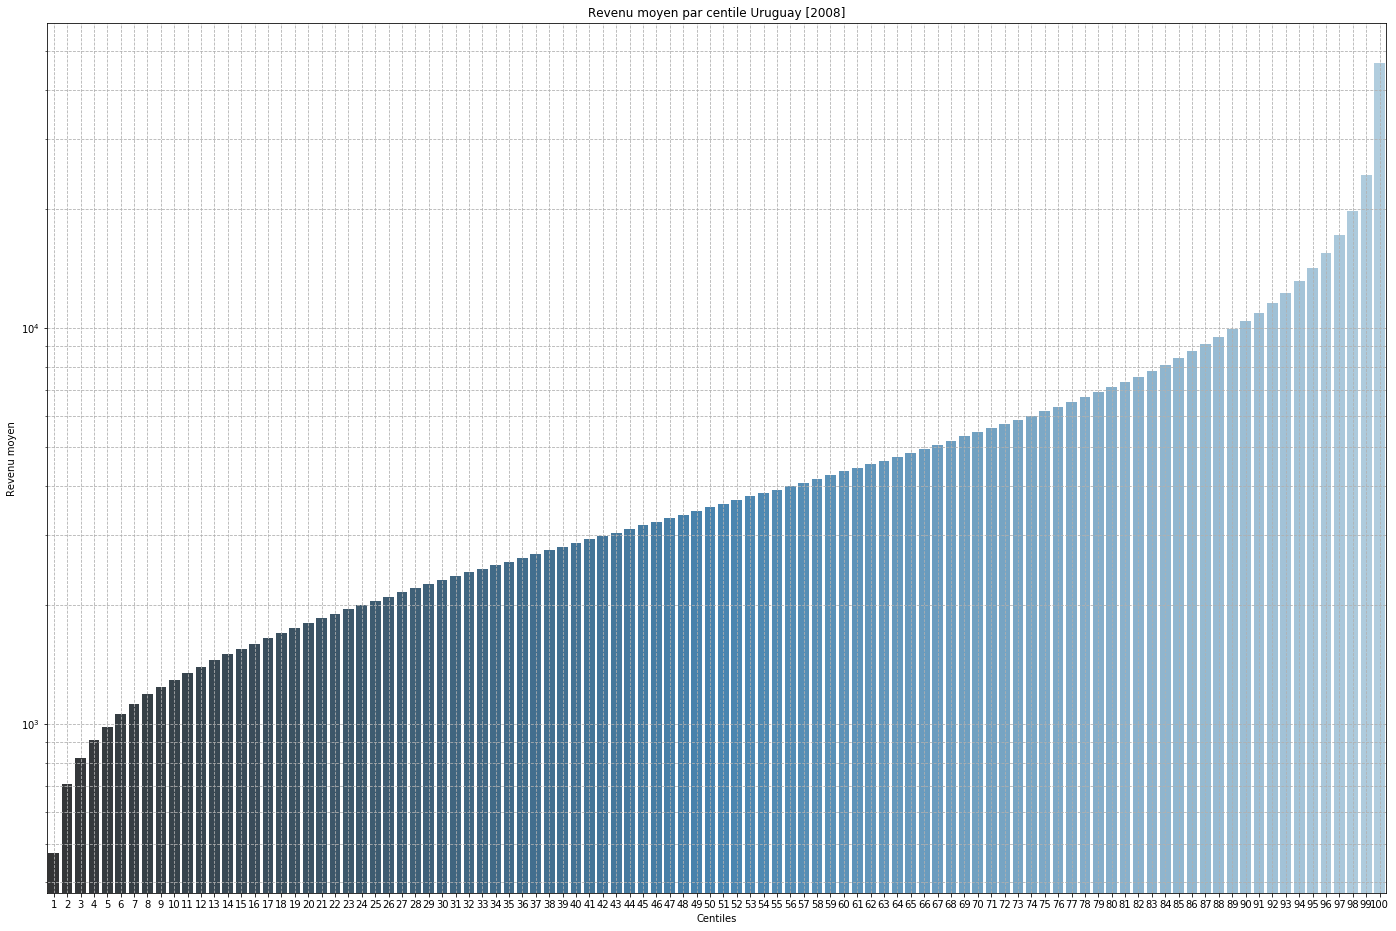

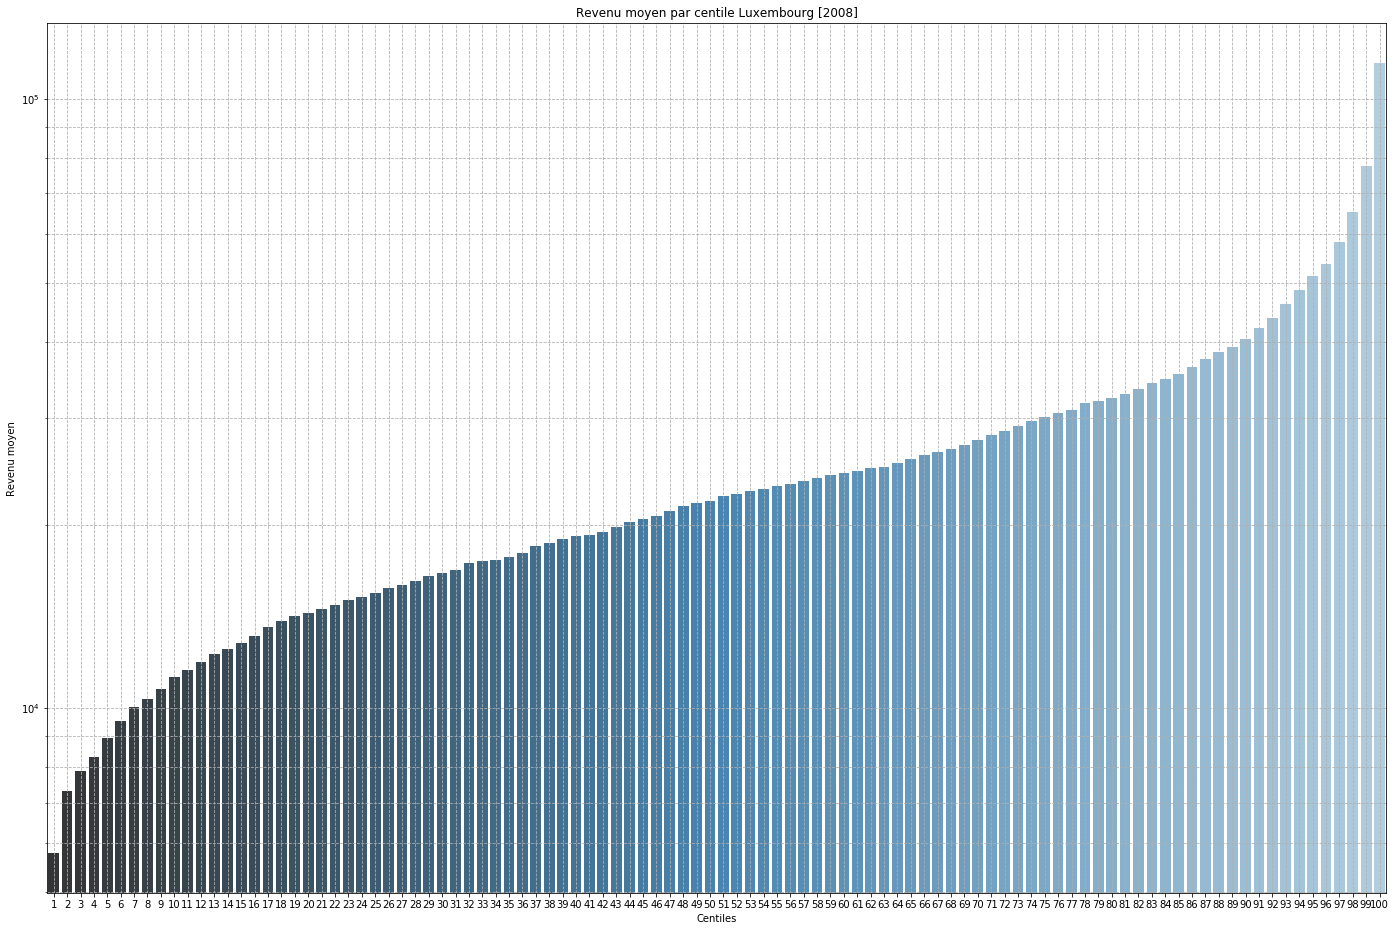

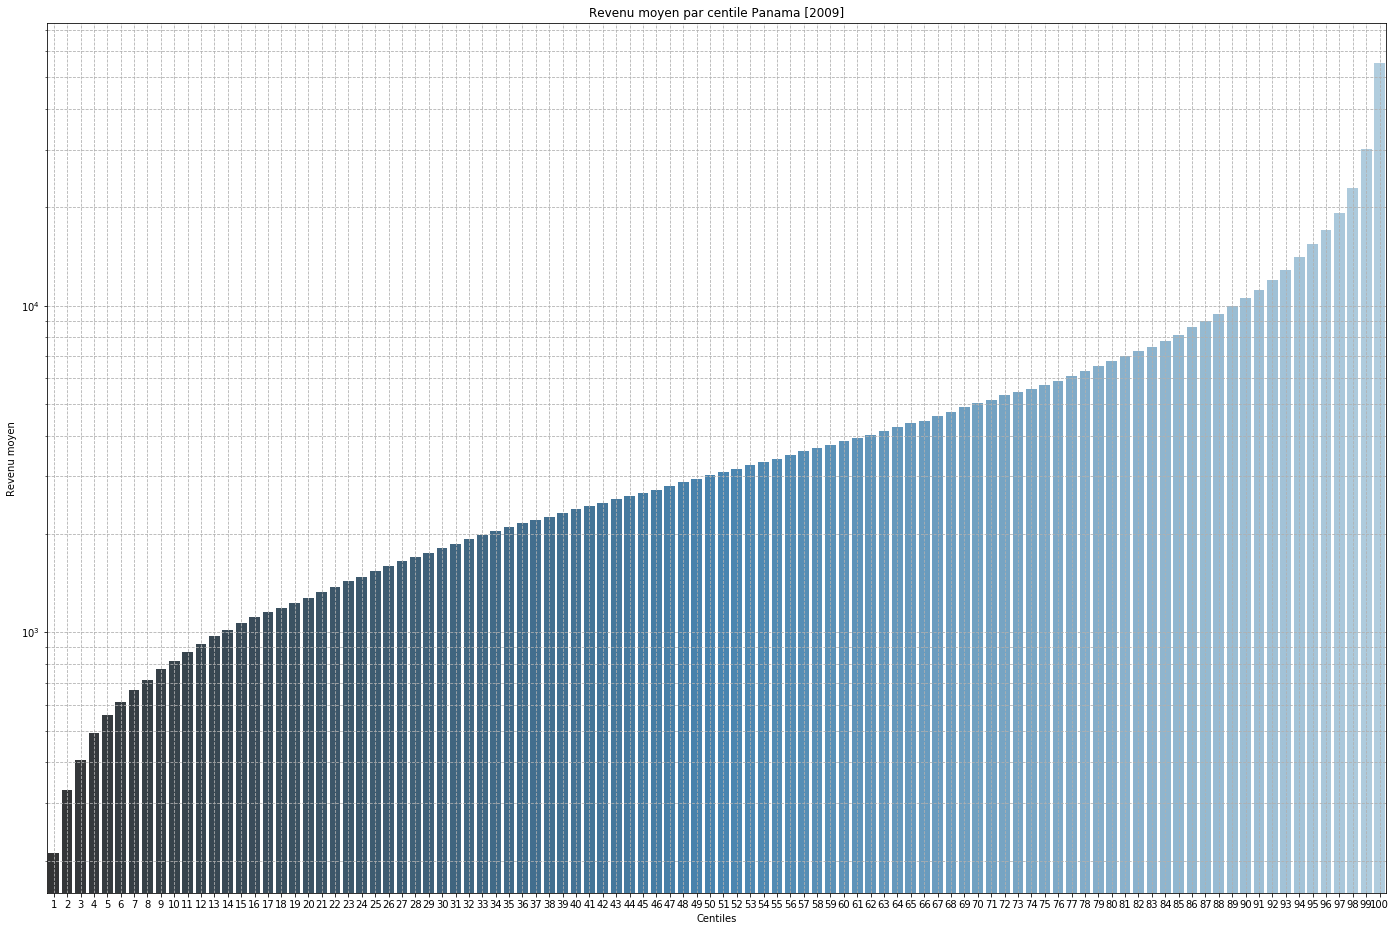

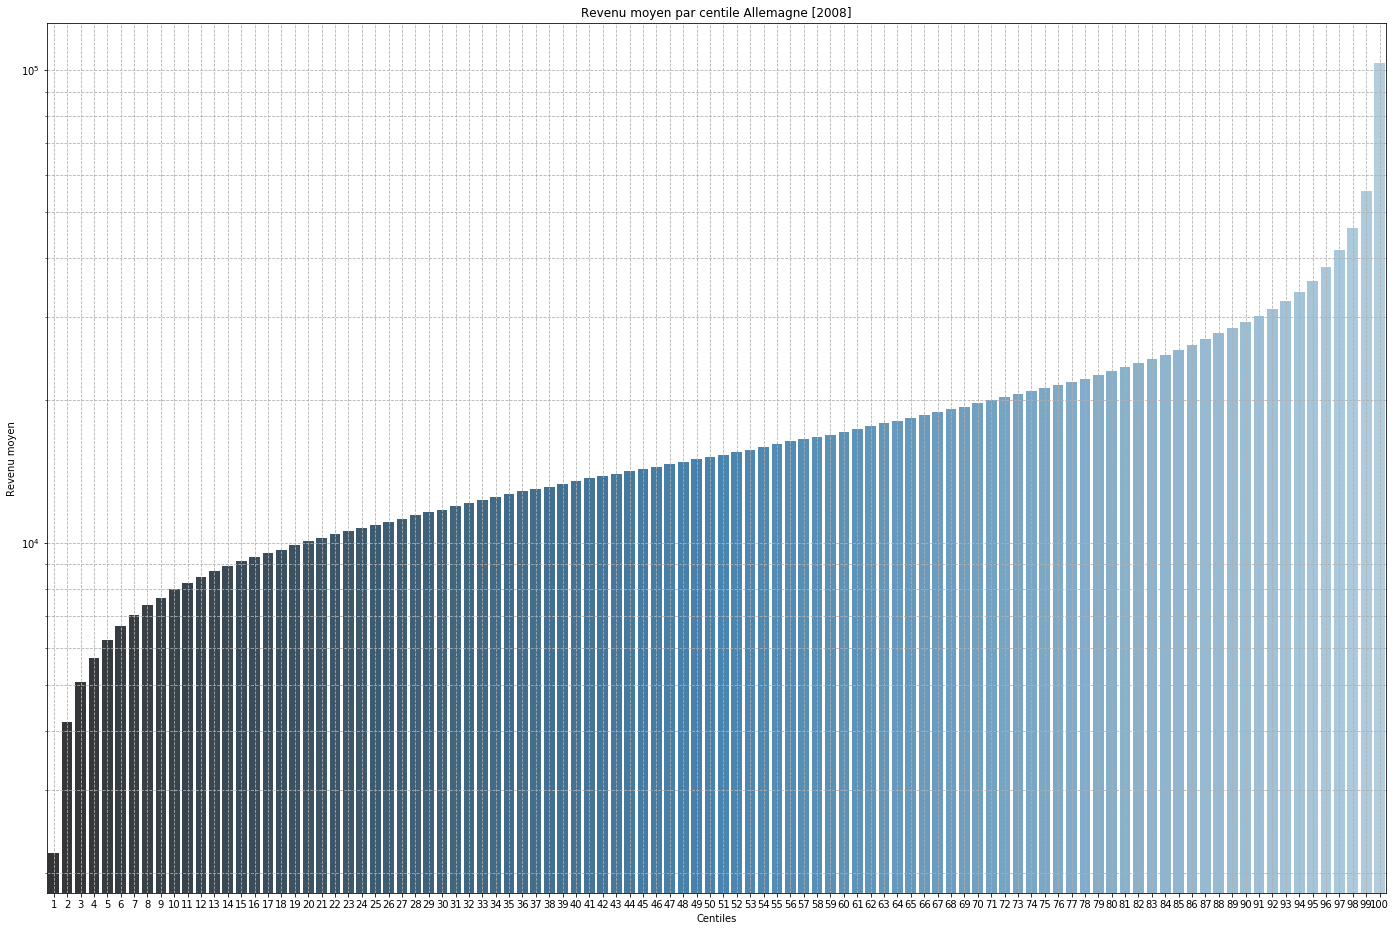

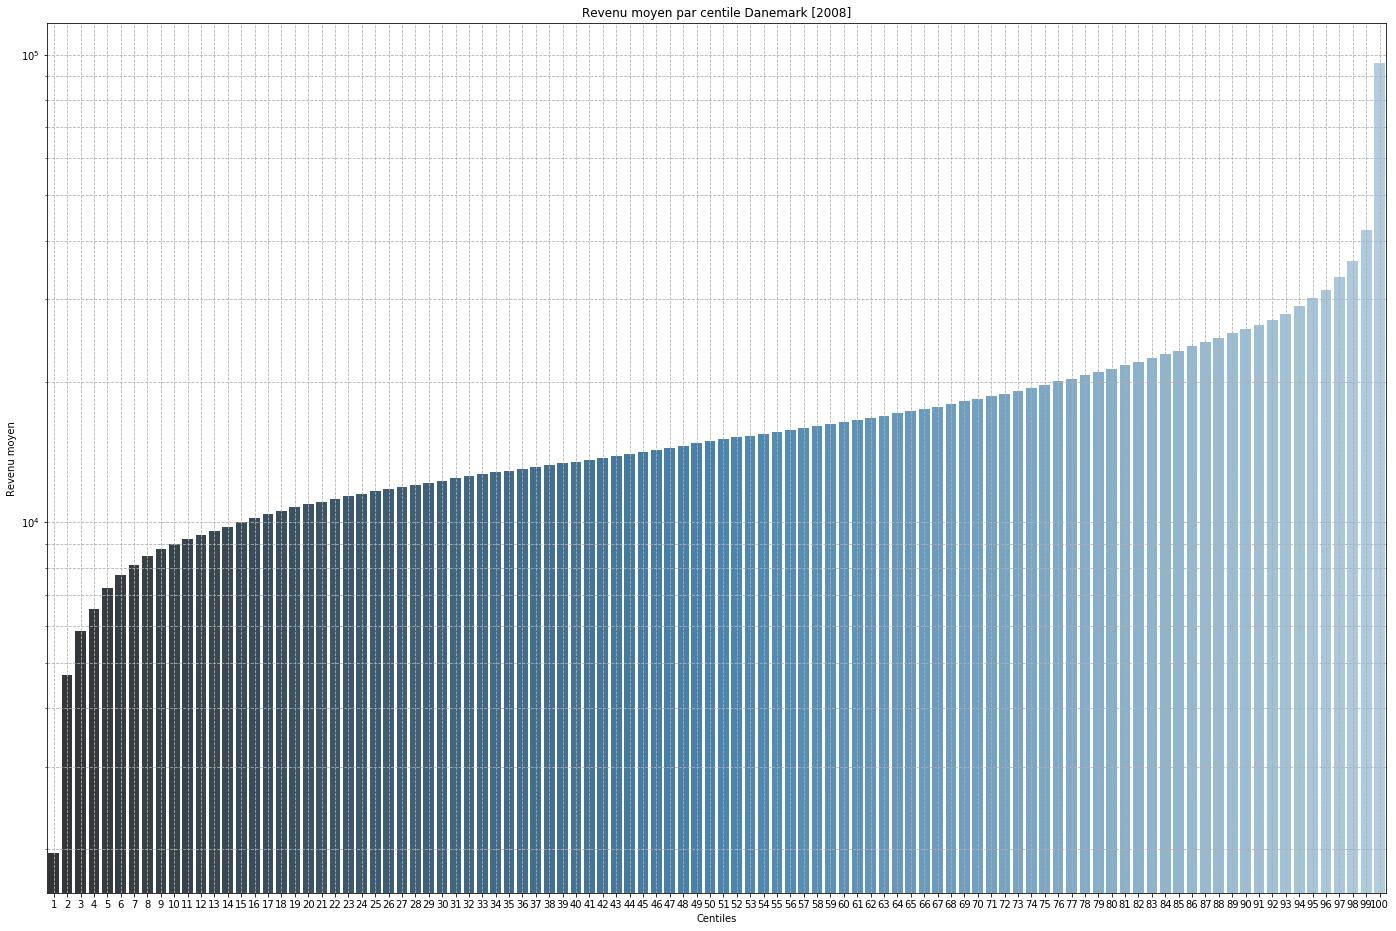

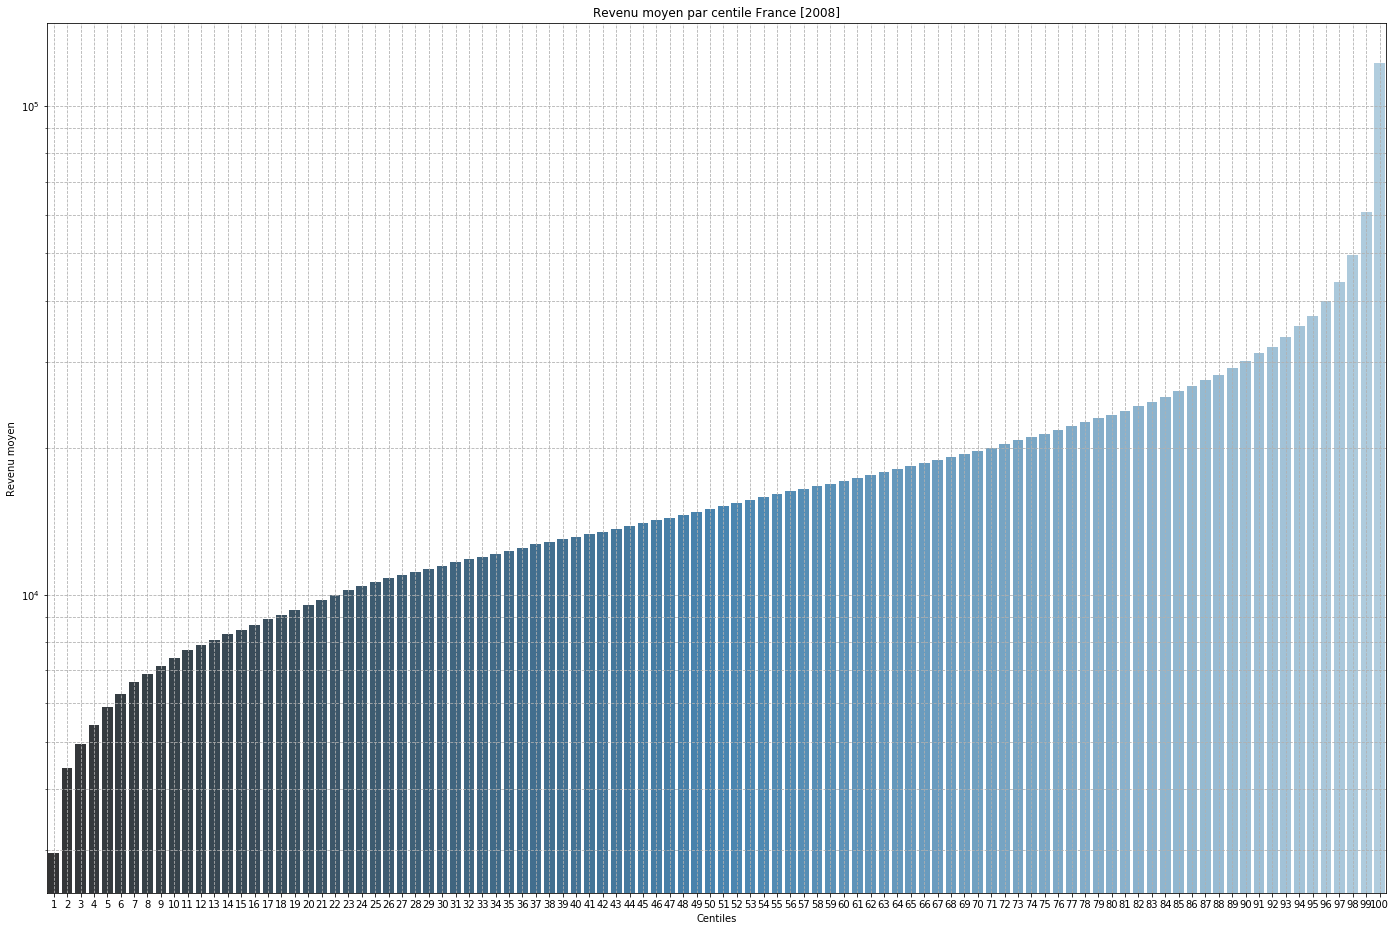

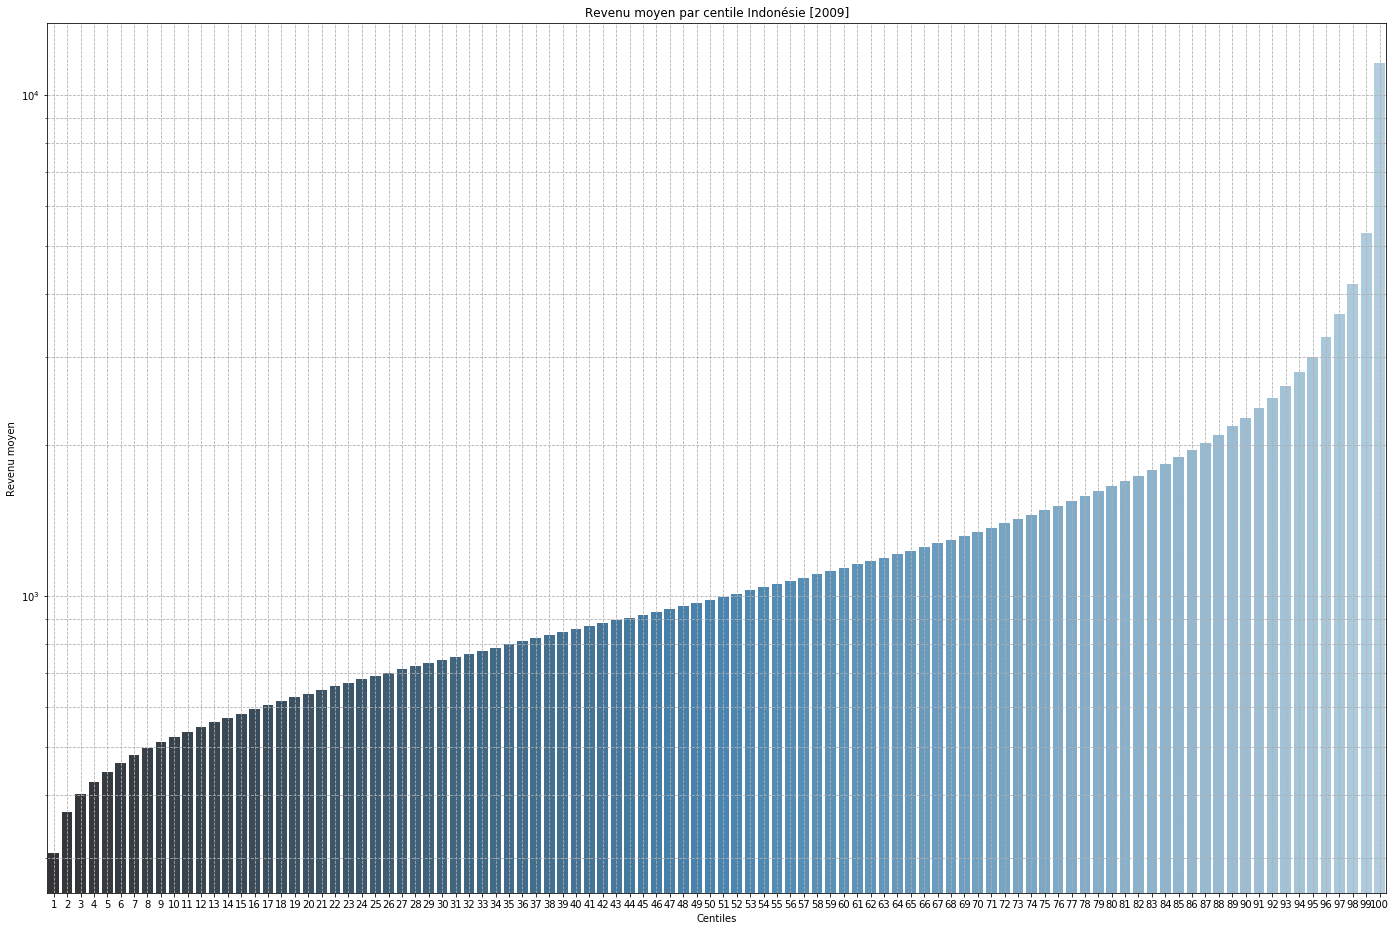

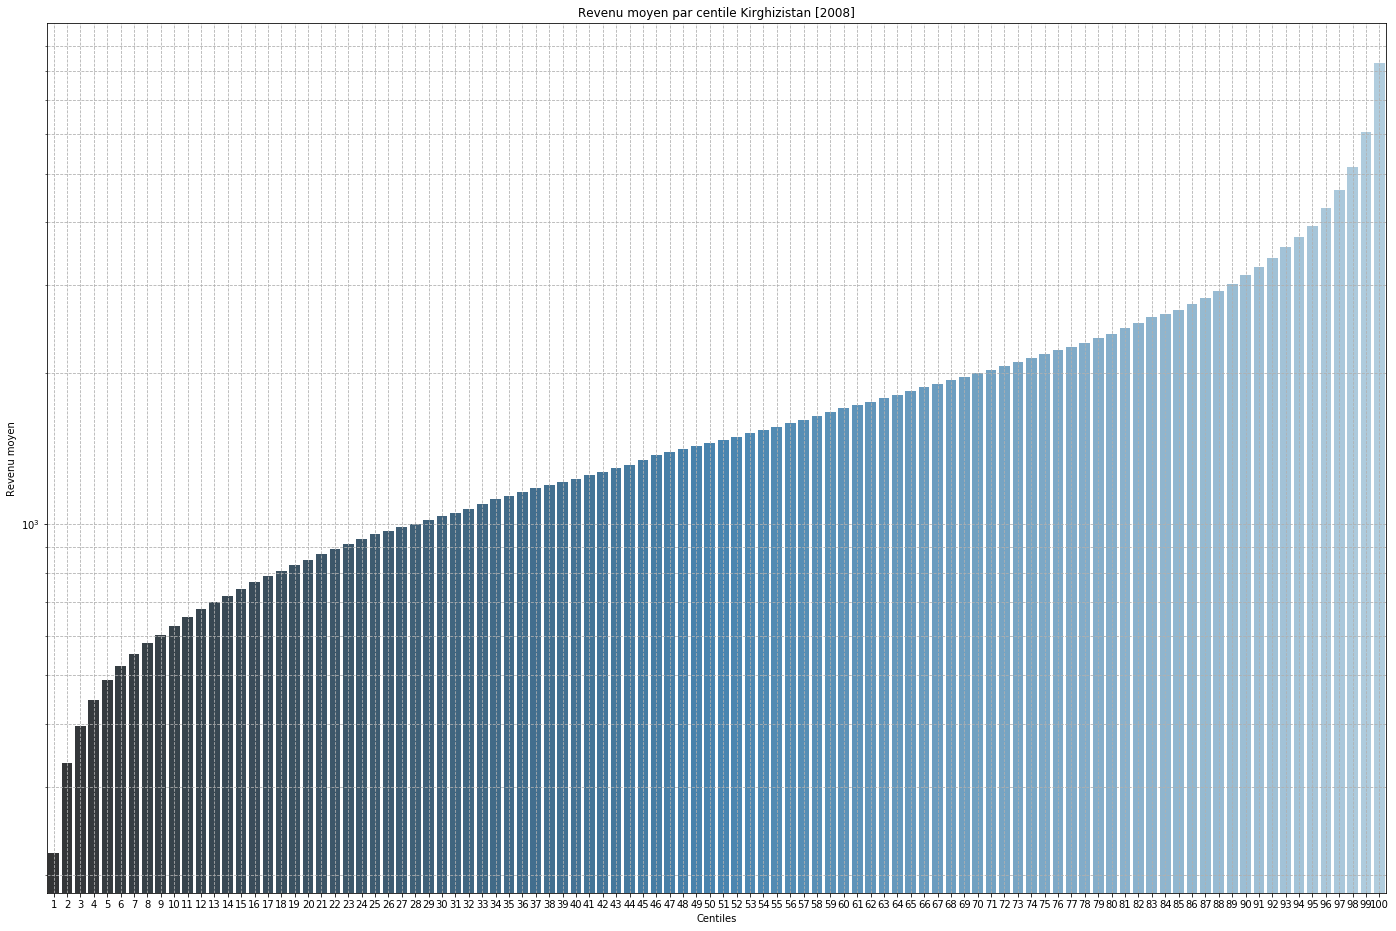

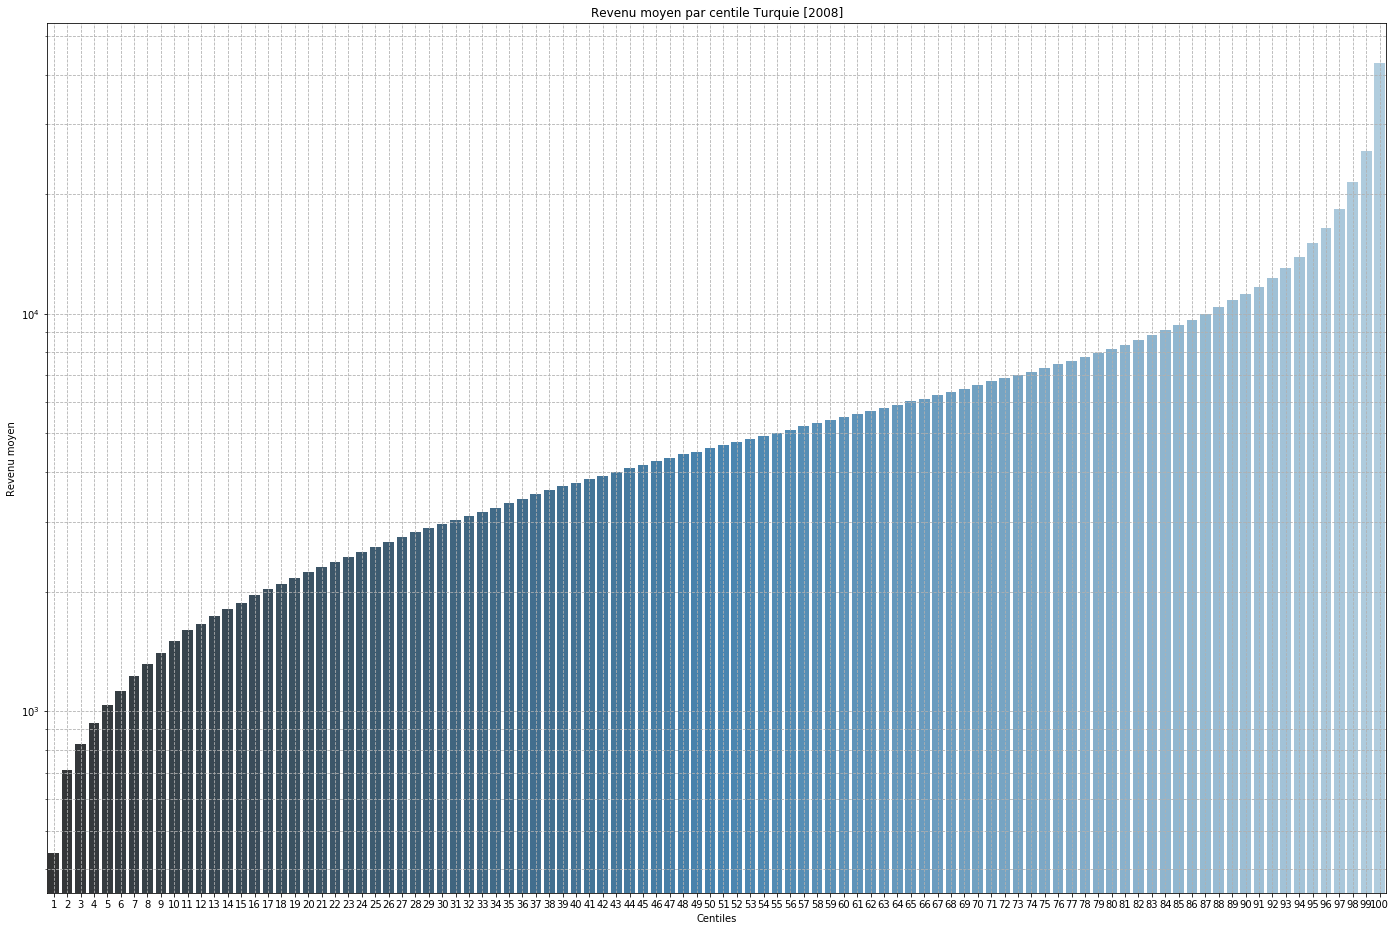

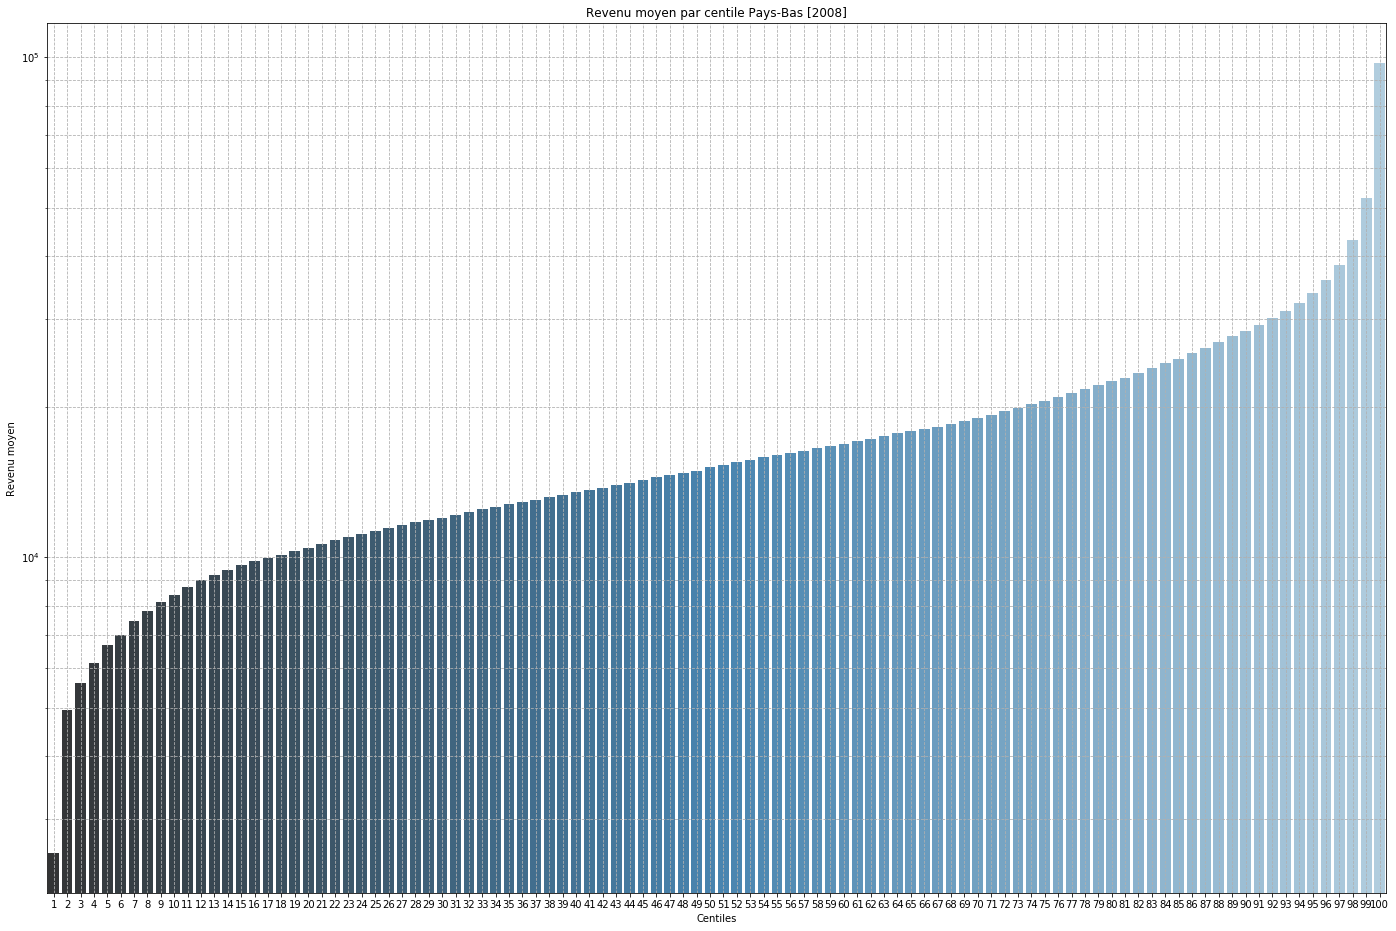

In [20]:
graph_log('URY', 'Uruguay')
graph_log('LUX', 'Luxembourg')
graph_log('PAN', 'Panama')
graph_log('DEU', 'Allemagne')
graph_log('DNK', 'Danemark')
graph_log('FRA', 'France')
graph_log('IDN', 'Indonésie')
graph_log('KGZ', 'Kirghizistan')
graph_log('TUR', 'Turquie')
graph_log('NLD', 'Pays-Bas')

Les graphiques suivent toutes la même tendance. Leur premier centile est toujours bien inférieur au second. De même, le dernier centile est toujours bien supérieur au précédent. 
**Ces centiles à chaque extrêmité représentent donc les outliers.**

**Courbes superposées :**

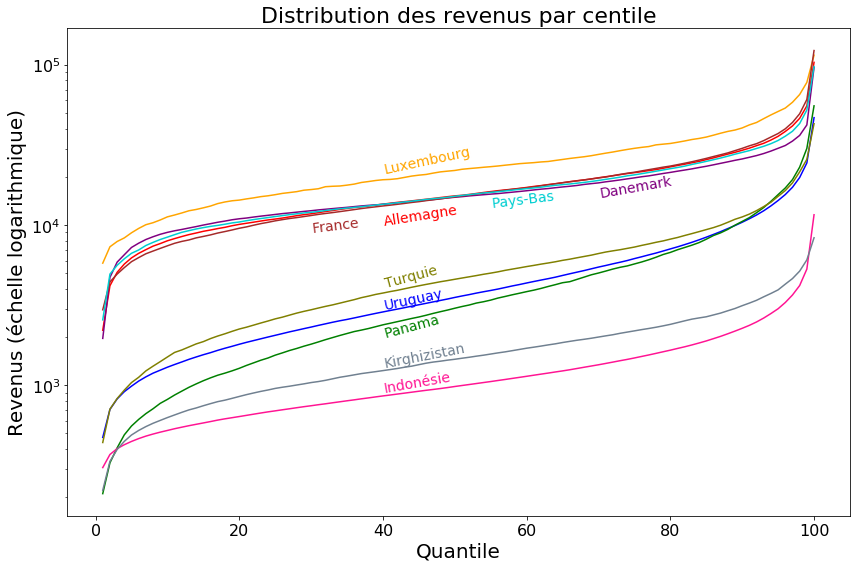

In [21]:
Dist_URY = data[data['country'] == 'URY']
Dist_LUX = data[data['country'] == 'LUX']
Dist_PAN = data[data['country'] == 'PAN']
Dist_DEU = data[data['country'] == 'DEU']
Dist_DNK = data[data['country'] == 'DNK']
Dist_FRA = data[data['country'] == 'FRA']
Dist_IDN = data[data['country'] == 'IDN']
Dist_KGZ = data[data['country'] == 'KGZ']
Dist_TUR = data[data['country'] == 'TUR']
Dist_NLD = data[data['country'] == 'NLD']

label = ['Uruguay',  'Luxembourg', 'Panama', 'Allemagne', 'Danemark', 'France','Indonésie','Kirghizistan','Turquie','Pays-Bas']


plt.figure(figsize=(12,8))
plt.yscale('log')

plt.plot(Dist_URY['quantile'], Dist_URY['income'], color='blue')
plt.text(40, 3000 , 'Uruguay', fontsize = '14', color='blue', rotation = 12)

plt.plot(Dist_LUX['quantile'], Dist_LUX['income'], color='orange')
plt.text(40, 21000 , 'Luxembourg', fontsize = '14', color='orange', rotation = 12)

plt.plot(Dist_PAN['quantile'], Dist_PAN['income'], color='green')
plt.text(40, 2000 , 'Panama', fontsize = '14', color='green', rotation = 15)

plt.plot(Dist_DEU['quantile'], Dist_DEU['income'], color='red')
plt.text(40, 10000 , 'Allemagne', fontsize = '14', color='red', rotation = 9)

plt.plot(Dist_DNK['quantile'], Dist_DNK['income'], color='purple')
plt.text(70, 15000 , 'Danemark', fontsize = '14', color='purple', rotation = 10)

plt.plot(Dist_FRA['quantile'], Dist_FRA['income'], color='brown')
plt.text(30, 9000 , 'France', fontsize = '14', color='brown', rotation = 7)

plt.plot(Dist_IDN['quantile'], Dist_IDN['income'], color='deeppink')
plt.text(40, 900 , 'Indonésie', fontsize = '14', color='deeppink', rotation = 10)

plt.plot(Dist_KGZ['quantile'], Dist_KGZ['income'], color='slategray')
plt.text(40, 1300 , 'Kirghizistan', fontsize = '14', color='slategray', rotation = 11)

plt.plot(Dist_TUR['quantile'], Dist_TUR['income'], color='olive')
plt.text(40, 4100 , 'Turquie', fontsize = '14', color='olive', rotation = 15)

plt.plot(Dist_NLD['quantile'], Dist_NLD['income'], color='darkturquoise')
plt.text(55, 13000 , 'Pays-Bas', fontsize = '14', color='darkturquoise', rotation = 7)

plt.title('Distribution des revenus par centile', fontsize=22)
plt.ylabel('Revenus (échelle logarithmique)', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('Quantile', fontsize=20)
plt.xticks(fontsize=16)
plt.tight_layout()

#plt.savefig('Distribution_superposees.png')
plt.show()

**Ce graphique permet de bien comparer les différents niveaux de richesses entre pays.**

La population du Luxembourg est la plus riche de ces 10 pays. Son premier centile est au même niveau que le dernier centile du Kirghizistan.

Les français, allemands, hollandais et danois ont un niveau de richesse équivalents.

Le peuple indonésien est en dernière position même si son dernier centile est au-dessus de celui du Kirghizistan.

<a id="chapitre_2_2"></a>
### <span style="color: #a40334">Courbe de Lorenz de chacun des pays choisis</span>

La courbe de Lorenz affiche la richesse cumulée par pourcentage de population.
Ainsi, si chaque quantile d'une population possède une richesse similaire, alors la richesse cumulée augmentera régulièrement et la courbe de Lorenz représentera finalement une droite d'équation $x = y$.

**Dans le cas d'une droite, la richesse est uniformément répartie.**

En revanche, si la droite devient courbe, alors la richesse est nettement plus concentrée au sein des derniers quantiles.

**Dans le cas d'une courbe, la richesse n'est pas uniformément répartie.**

In [22]:
def Lorenz (country, country_name):
    
    df = data[data.country== country]
    annee = df.Année.unique()
    
    plt.figure(figsize=(12,8))

    income = df['income'].values

    n = len(income)
    lorenz = np.cumsum(np.sort(income)) / income.sum() 
    lorenz = np.append([0],lorenz) 

    plt.axes().axis('equal')
    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    
    ax = plt.axes()
    ax = ax.set(xlabel='Pourcentage cumulé population', ylabel='Pourcentage cumulé revenu moyen')

    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.title(f"Courbe de Lorenz des revenus {country_name} {annee}", fontsize=18)
    #plt.savefig(f"Courbe de Lorenz des revenus {country_name}.png")
    plt.show()

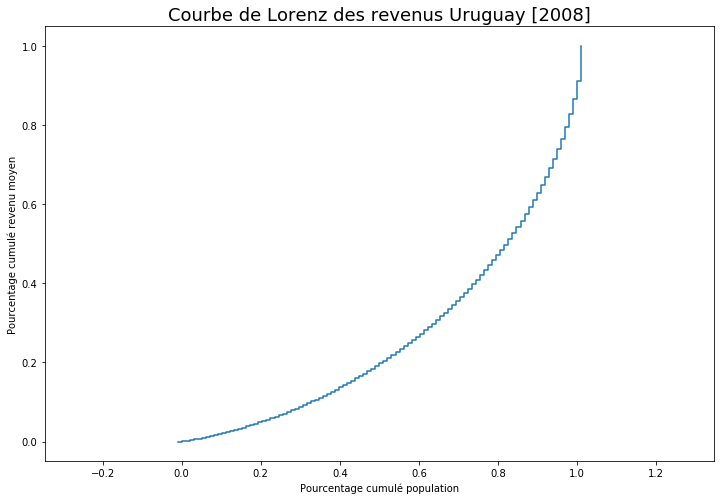

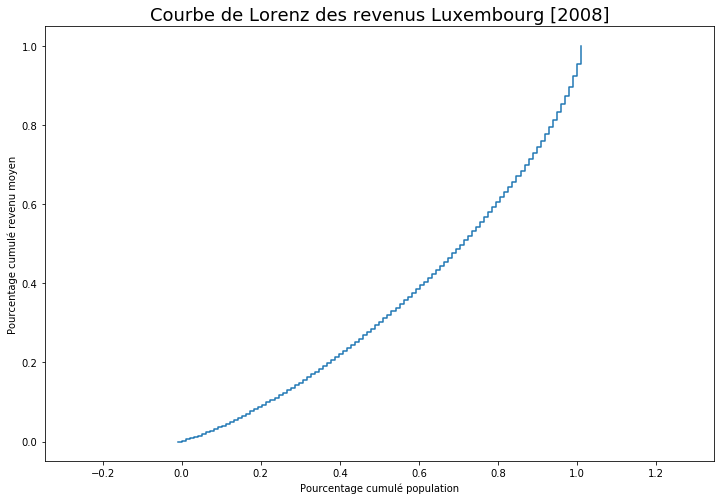

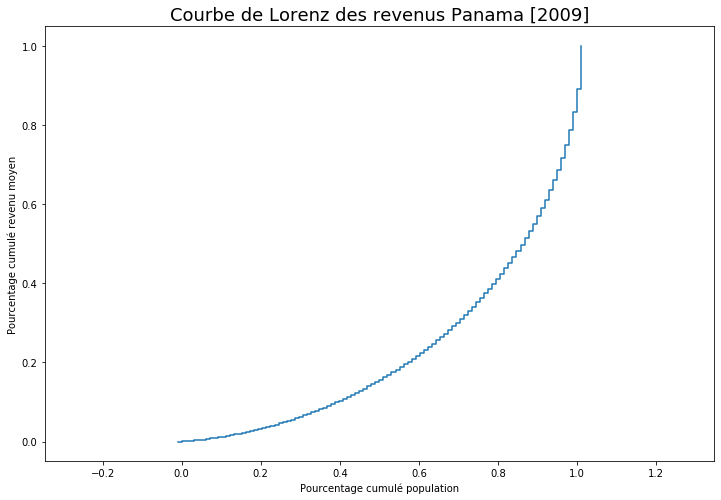

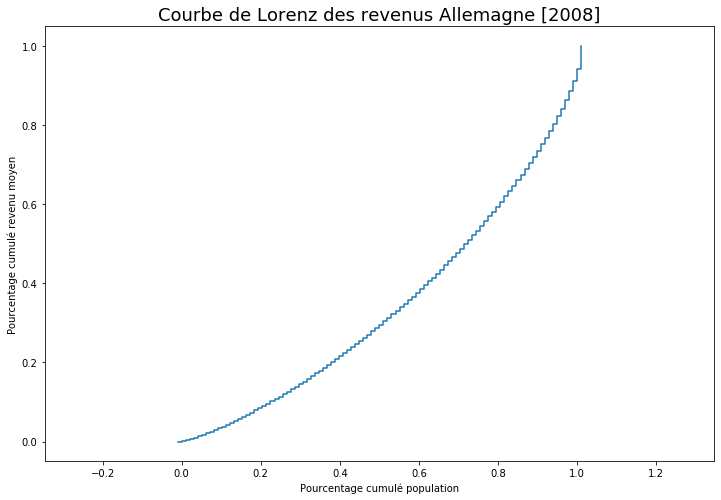

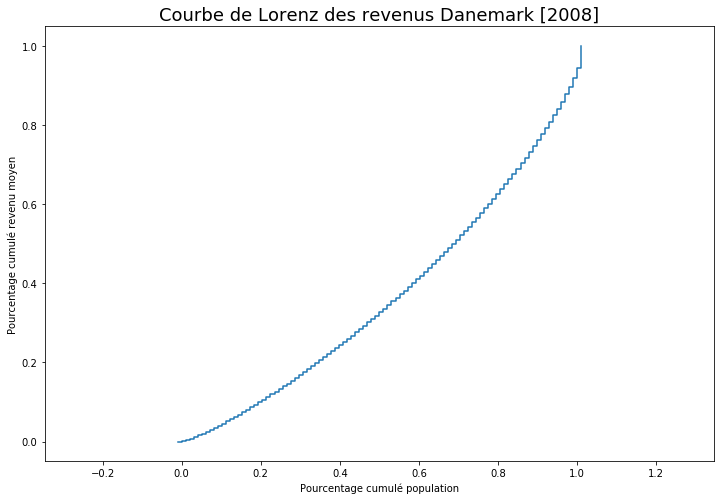

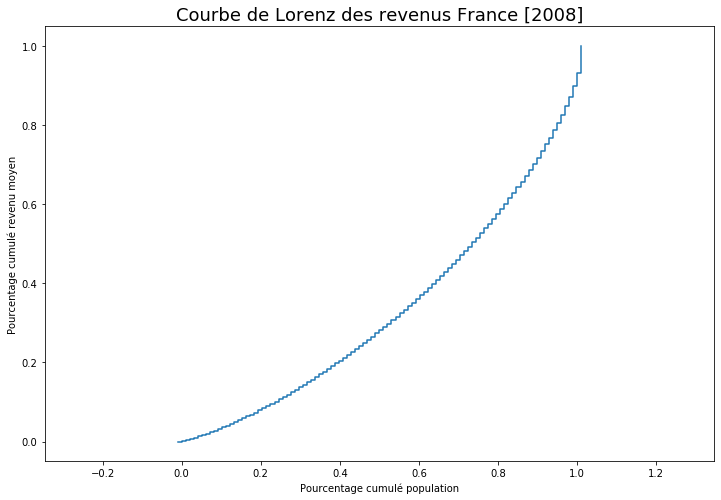

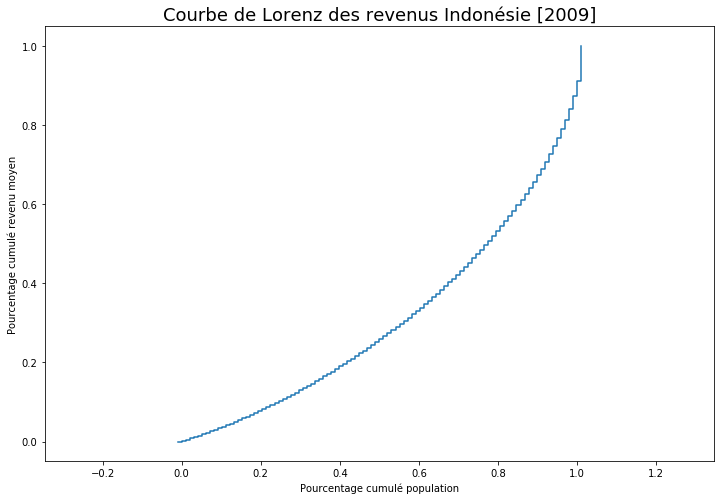

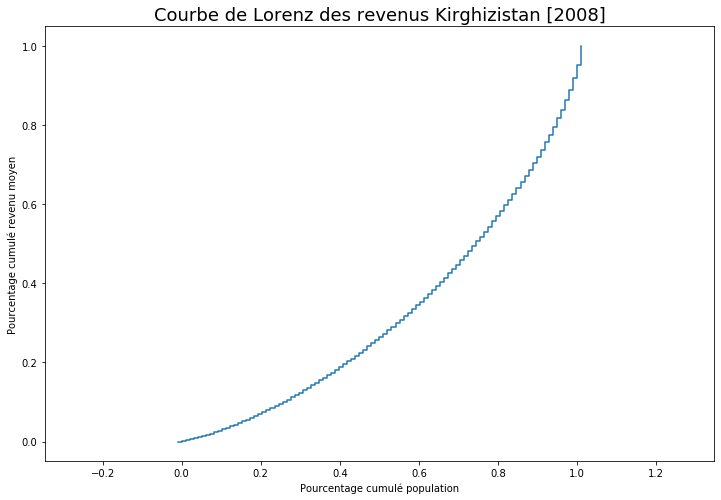

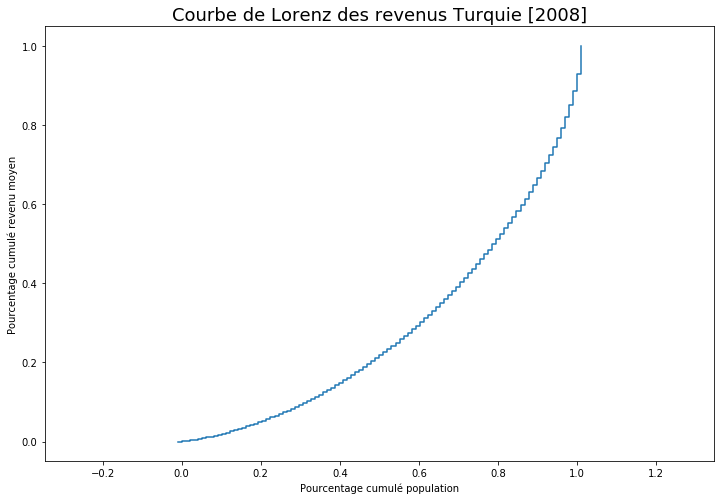

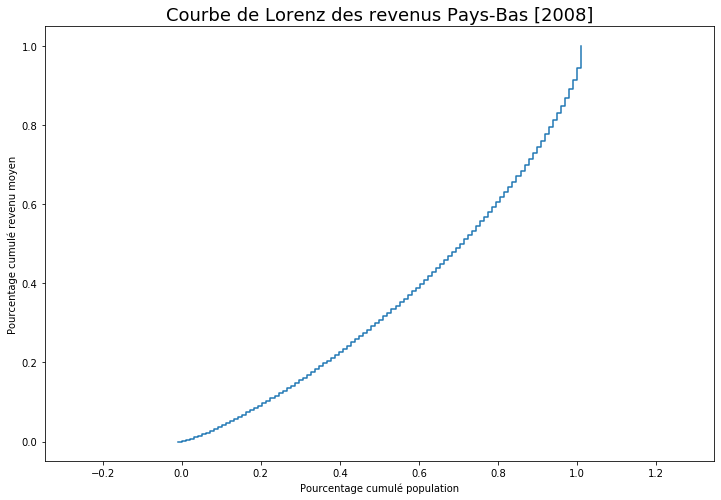

In [23]:
Lorenz ('URY', 'Uruguay')
Lorenz ('LUX', 'Luxembourg')
Lorenz ('PAN', 'Panama')
Lorenz ('DEU', 'Allemagne')
Lorenz ('DNK', 'Danemark')
Lorenz ('FRA', 'France')
Lorenz ('IDN', 'Indonésie')
Lorenz ('KGZ', 'Kirghizistan')
Lorenz ('TUR', 'Turquie')
Lorenz ('NLD', 'Pays-Bas')

La courbe de Lorenz du Panama en 2009 progresse le moins rapidement, cela démontre que pour ce pays, les richesses sont les plus concentrées parmi les derniers quantiles de la population, soit une minorité.

L'uruguay et l'Indonésie en 2008, ainsi que la Turquie en 2009, affichent également des courbes de Lorenz qui progressent lentement. Pour ces pays, les richesses sont également concentrées au sein d'une minorité de la population mais de manière moins importante que pour le Panama en 2009.

La France, l'Allemagne, les Pays-Bas, le Kirghizstan, le Luxembourg ont une courbe qui évolue encore moins rapidement : les richesses sont mieux réparties.

Enfin, la courbe de Lorenz du Danemark est proche d'une droite, ce qui démontre une répartition relativement égale des richesses.

<a id="chapitre_2_3"></a>
### <span style="color: #a40334">Évolution de l'indice de Gini au fil des ans</span>

L'indice de Gini est égale à deux fois la surface délimitée par la droite d'équation $x = y$ et par la courbe de Lorenz et permet de mesurer l'inégalité de la répartition des richesses dans une population.
Compris entre 0 et 1 (dans notre étude, 0 et 100), plus l'indice est grand et plus la richesse est inégalitairement répartie.

In [24]:
dataGini = pd.read_csv('Gini.csv', sep=";", decimal = ",")
dataGini = dataGini.loc[:,('Country Code','2004','2006','2007','2008','2009','2010','2011')]
dataGini = dataGini.rename(columns={'Country Code':'country'})
dataGini = pd.merge(codePays,dataGini)

dataGini.head(3)

,country,Zone,2004,2006,2007,2008,2009,2010,2011
0,ALB,Albanie,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,ARG,Argentine,48.6,46.7,46.6,45.3,44.1,44.5,42.7
2,ARM,Arménie,37.5,29.7,31.2,29.2,28.0,30.0,29.4


In [25]:
def Evolution_Gini(country,country_name):
        
    df = dataGini[dataGini.country == country]
    
    df = df.reset_index()\
           .drop(columns={'index','country','Zone'})\
           .loc[0]
    df = pd.DataFrame(data= df)
    df = df.rename(columns={0:'Indice de Gini'})   
    sns.pointplot(x = df.index,y= df['Indice de Gini'],data = df)

    plt.title(f"Évolution indice de Gini {country_name}")
    #plt.savefig(f"Évolution indice de Gini {country_name}.png")

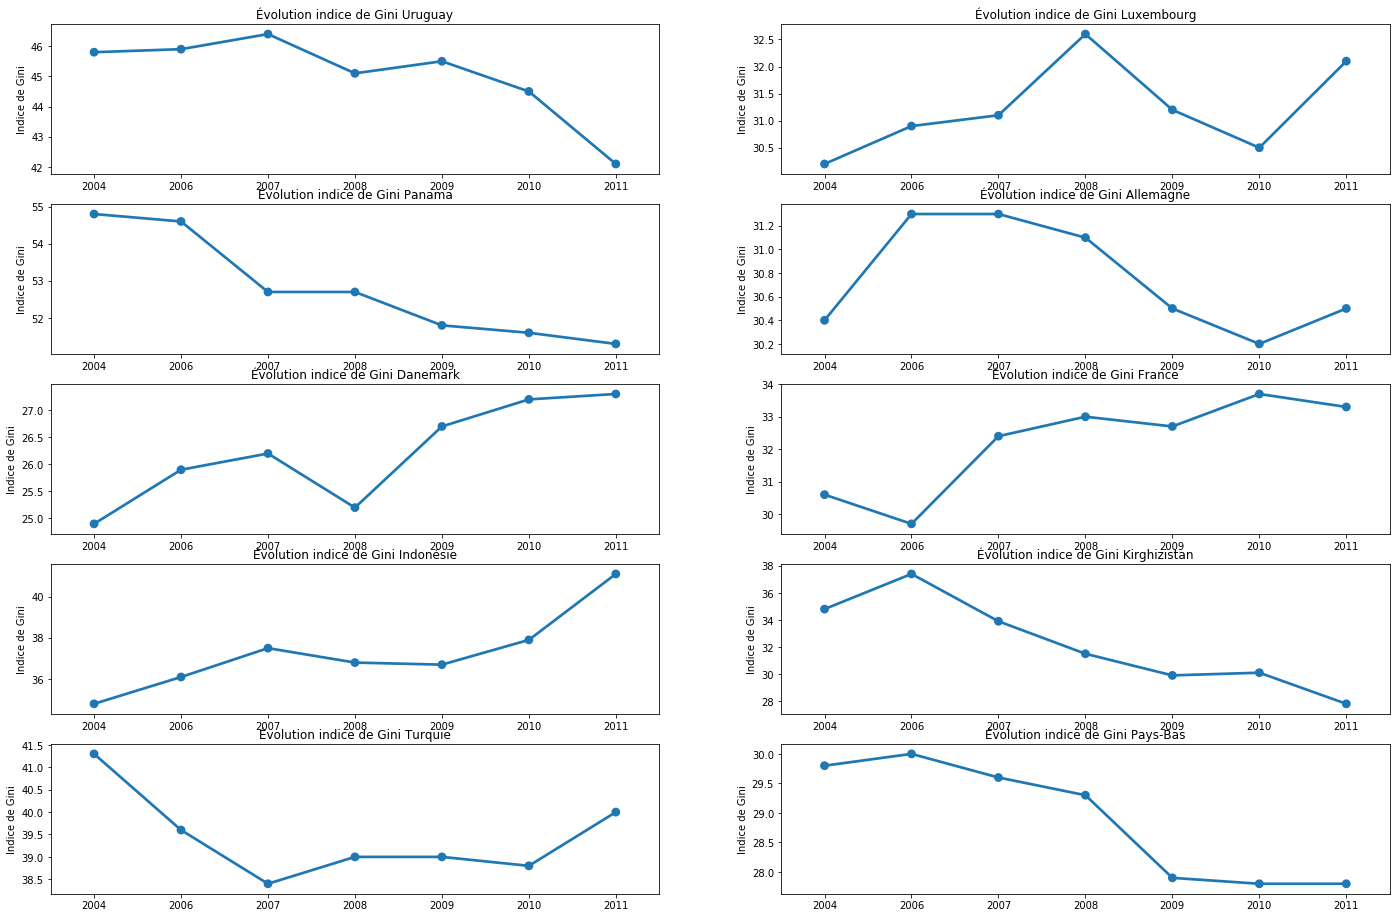

In [26]:
plt.figure(figsize=(24,16))

plt.subplot(5,2,1)
Evolution_Gini('URY','Uruguay')
plt.subplot(5,2,2)
Evolution_Gini('LUX','Luxembourg')
plt.subplot(5,2,3)
Evolution_Gini('PAN','Panama')
plt.subplot(5,2,4)
Evolution_Gini('DEU','Allemagne')
plt.subplot(5,2,5)
Evolution_Gini('DNK','Danemark')
plt.subplot(5,2,6)
Evolution_Gini('FRA','France')
plt.subplot(5,2,7)
Evolution_Gini('IDN','Indonésie')
plt.subplot(5,2,8)
Evolution_Gini('KGZ','Kirghizistan')
plt.subplot(5,2,9)
Evolution_Gini('TUR','Turquie')
plt.subplot(5,2,10)
Evolution_Gini('NLD','Pays-Bas')

Pour les Pays-Bas, le Kirghizistan, le Panama, et l'Uruguay, l'indice de Gini baisse au fil des années, permettant de déduire une meilleure répartition des richesses. **Toutefois, l'indice de Gini de l'Uruguay et du Panama restent élevés en 2011.**

L'Indonésie, le Danemark, le Luxembourg et la France ont un indice de Gini qui augmente au fil des années. Les écarts de richesses se creusent donc entre les quantiles de la population de ces pays.

Hormis le Kirghizistan, nous remarquons pour les autres pays un changement de tendance au niveau de **2008**, vraisemblablement causé par la crise financière.

<a id="chapitre_2_4"></a>
### <span style="color: #a40334">Classement des pays selon moyenne de l'indice de Gini</span>

In [27]:
Classement = dataGini.drop(columns='country')\
                     .set_index('Zone')\
                     .dropna(how='all')\
                     .bfill(axis=1).ffill(axis=1)

Classement['Mean_Gini'] = (Classement['2004']+Classement['2006']+Classement['2007']+Classement['2008']+Classement['2009']+Classement['2010']+Classement['2011'])/7

Classement = Classement.sort_values(by='Mean_Gini')

Classement['index'] = range(1, len(Classement) + 1)

Classement = Classement.reset_index()\
                       .set_index('index')\
                       .loc[:,('Zone','Mean_Gini')]


Classement

,Zone,Mean_Gini
index,,
1,Slovénie,24.557143
2,Danemark,26.200000
3,Slovaquie,26.371429
4,Tchéquie,26.528571
5,Azerbaïdjan,26.600000
...,...,...
105,Guatemala,54.600000
106,Colombie,54.842857
107,Honduras,55.357143


##### Moyenne mondiale de l'indice de Gini

In [28]:
MoyenneGini = Classement.Mean_Gini.mean()

print("La moyenne mondiale de l'indice de Gini est de",round(MoyenneGini,2),".")

La moyenne mondiale de l'indice de Gini est de 37.9 .


##### Les 5 pays ayant l'indice le plus élevé

In [29]:
Classement.tail(5)

,Zone,Mean_Gini
index,,
105,Guatemala,54.600000
106,Colombie,54.842857
107,Honduras,55.357143
108,République centrafricaine,56.200000
109,Afrique du Sud,63.171429


##### Les 5 pays ayant l'indice le plus faible

In [30]:
Classement.head(5)

,Zone,Mean_Gini
index,,
1,Slovénie,24.557143
2,Danemark,26.200000
3,Slovaquie,26.371429
4,Tchéquie,26.528571
5,Azerbaïdjan,26.600000


##### Position de la France

In [31]:
ClassementFrance = Classement[Classement.Zone=='France']

print("La France se trouve en",ClassementFrance.index[0],"ème position.")

La France se trouve en 30 ème position.


<a id="chapitre_3"></a>
## <span style="color: #030aa4">Mission 3</span>

In [32]:
CoeffElas = pd.read_csv('GDIMMay2018.csv')

CoeffElas.head(3)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1


<a id="chapitre_3_1"></a>
### <span style="color: #a40334">1. Génération d'un nombre de $n$ réalisations d'une variable $ln(Y_{parent})$ selon une loi normale</span>

In [33]:
ln_y_parent = st.norm(0,1).rvs(size=100000)

ln_y_parent

array([-0.70936791, -0.4366453 ,  1.62677159, ..., -0.91288904,
        0.88825249, -0.64778063])

<a id="chapitre_3_2"></a>
### <span style="color: #a40334">2. Génération d'un nombre de $n$ réalisations du terme d'erreur epsilon selon une loi normale de moyenne 0 et d'écart-type 1</span>

In [34]:
residues = st.norm(0,1).rvs(size=100000)

residues

array([ 0.88114917, -0.37247628,  0.55045513, ..., -1.86166065,
        0.47387905, -0.67481275])

<a id="chapitre_3_3"></a>
### <span style="color: #a40334"> 3. Pour une valeur de $p_{j}$ (par exemple 0,9), calculez : <font size="4">$y_{child} = e^{\alpha+p_{j}ln(y_{parent}+\epsilon)}$</font>. Le choix de $\alpha$ n'a aucune importance et peut être supprimé.</span>

In [35]:
def generate_incomes(n, pj):

    # On génère les revenus des parents (exprimés en logs) selon une loi normale.

    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)

    ln_y_parent = st.norm(0,1).rvs(size=n)

    # Génération d'une réalisation du terme d'erreur epsilon

    residues = st.norm(0,1).rvs(size=n)

    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [36]:
generate_incomes(100000, 0.9)[0]

array([0.3263571 , 0.58523994, 2.2945964 , ..., 2.08266396, 4.81299312,
       7.50659595])

<a id="chapitre_3_4"></a>
### <span style="color: #a40334"> 4. Pour chacun des n individus générés, calculez la classe de revenu $c_{i,child}$ ainsi que la classe de revenu de ses parents $c_{i,parent}$, à partir de $y_{child}$ et $y_{parent}$.</span>

In [37]:
def quantiles(l, nb_quantiles):

    size = len(l)

    l_sorted = l.copy()

    l_sorted = l_sorted.sort_values()

    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)

    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}

    return pd.Series([q_dict[e] for e in l])

In [38]:
def compute_quantiles(y_child, y_parents, nb_quantiles):
 
    y_child = pd.Series(y_child)

    y_parents = pd.Series(y_parents)

    c_i_child = quantiles(y_child, nb_quantiles)

    c_i_parent = quantiles(y_parents, nb_quantiles)

    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)

    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]

    return sample

In [39]:
y_child,y_parents = generate_incomes(100000, 0.9)
nb_quantiles = 100

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

sample

,y_child,y_parents,c_i_child,c_i_parent
0,16.670980,12.098473,99,100
1,3.680764,7.469578,84,98
2,3.990805,1.400257,85,64
3,0.198326,0.243229,12,8
4,0.297636,0.525078,19,27
...,...,...,...,...
99995,2.568558,1.801306,76,73
99996,0.471057,0.442819,29,21
99997,0.410990,0.741087,26,39
99998,0.134117,0.230212,7,8


<a id="chapitre_3_5"></a>
### <span style="color: #a40334"> 5. À partir de cette dernière information, estimez pour chaque $c_{i,child}$, la distribution conditionnelle de $c_{i,parent}$.</span>

In [40]:
def distribution(counts, nb_quantiles):

    distrib = []

    total = counts["counts"].sum()

    

    if total == 0 :

        return [0] * nb_quantiles

    

    for q_p in range(1, nb_quantiles+1):

        subset = counts[counts.c_i_parent == q_p]

        if len(subset):

            nb = subset["counts"].values[0]

            distrib += [nb / total]

        else:

            distrib += [0]

    return distrib   


def conditional_distributions(sample, nb_quantiles):

    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)

    counts = counts.reset_index()

    counts.columns = ["c_i_child","c_i_parent","counts"]

    

    mat = []

    for child_quantile in np.arange(nb_quantiles)+1:

        subset = counts[counts.c_i_child == child_quantile]

        mat += [distribution(subset, nb_quantiles)]

    return np.array(mat)

def proba_cond(c_i_parent, c_i_child, mat):

    return mat[c_i_child, c_i_parent]

In [41]:
cd = conditional_distributions(sample, nb_quantiles)

cd

array([[0.242, 0.102, 0.084, ..., 0.   , 0.   , 0.   ],
       [0.124, 0.085, 0.08 , ..., 0.   , 0.   , 0.   ],
       [0.082, 0.085, 0.069, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.064, 0.087, 0.09 ],
       [0.   , 0.   , 0.   , ..., 0.068, 0.092, 0.12 ],
       [0.   , 0.   , 0.   , ..., 0.071, 0.134, 0.245]])

In [42]:
counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
counts = counts.reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"]
counts['proba_cond'] = counts.counts/1000

counts.head(3)

,c_i_child,c_i_parent,counts,proba_cond
0,1,1,242,0.242
1,1,2,102,0.102
2,1,3,84,0.084


<a id="chapitre_3_6"></a>
### <span style="color: #a40334"> 6. Graphique représentant ces ditributions conditionnelles.</span>

In [43]:
def plot_conditional_distributions(p, cd, nb_quantiles):

    plt.figure(figsize=(12,8))

    

    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

    cumul = np.array([0] * nb_quantiles)

    

    for i, child_quantile in enumerate(cd):

        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")

        cumul = cumul + np.array(child_quantile)


    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])

    plt.title("p=" + str(p))

    plt.legend()

    plt.xlabel("quantile parents")

    plt.ylabel("probabilité du quantile enfant")
    #plt.savefig("Distribution_conditionnelle.png")
    plt.show()

**Les graphiques ne seront représentés qu'avec 10 quantiles pour en faciliter la lecture.**

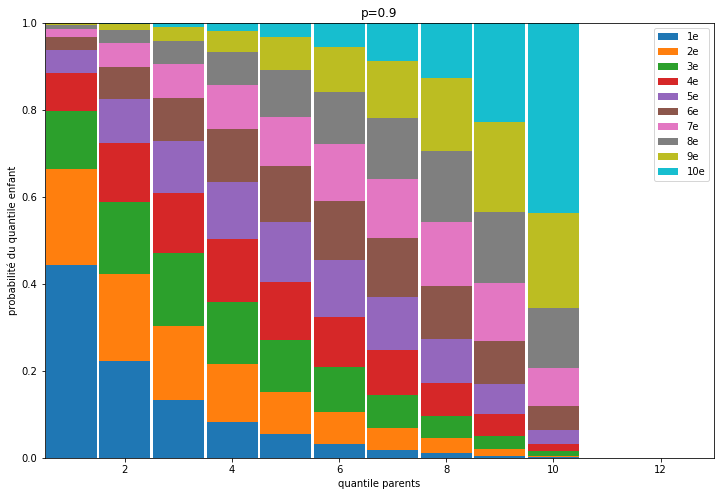

In [44]:
pj1 = 0.9
nb_quantiles1 = 10
n1 = 1000*nb_quantiles
y_child1, y_parents1 = generate_incomes(n1,pj1)

sample1 =  compute_quantiles(y_child1, y_parents1, nb_quantiles1)

cd1 = conditional_distributions(sample1, nb_quantiles1)

plot_conditional_distributions(pj1, cd1, nb_quantiles1)

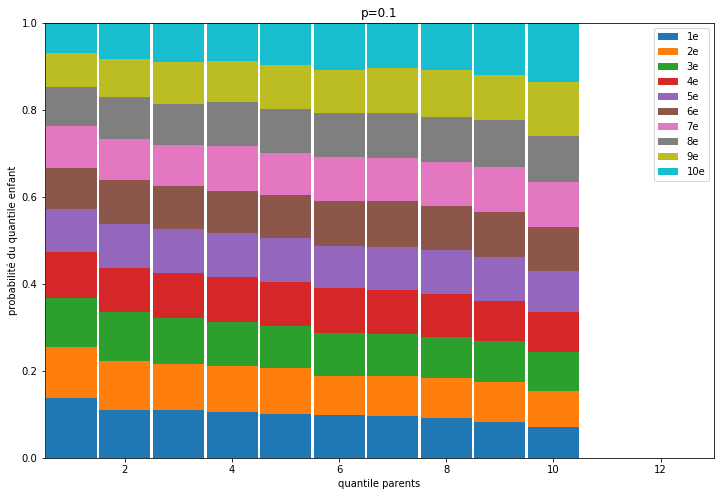

In [45]:
pj2 = 0.1
nb_quantiles1 = 10
n1 = 1000*nb_quantiles
y_child1, y_parents1 = generate_incomes(n1,pj2)

sample1 =  compute_quantiles(y_child1, y_parents1, nb_quantiles1)

cd1 = conditional_distributions(sample1, nb_quantiles1)

plot_conditional_distributions(pj2, cd1, nb_quantiles1)

<a id="chapitre_3_7"></a>
### <span style="color: #a40334"> 7. Effaçage des individus et conservation des distributions conditionnelles.</span>

In [46]:
dist_cond = counts.loc[ : ,('proba_cond')]

dist_cond

0       0.242
1       0.102
2       0.084
3       0.075
4       0.056
        ...  
9103    0.055
9104    0.077
9105    0.071
9106    0.134
9107    0.245
Name: proba_cond, Length: 9108, dtype: float64

<a id="chapitre_3_8"></a>
### <span style="color: #a40334"> 8. Création de 499 clones de chaque individu de la World Income Distribution.</span>

In [47]:
data_clones = pd.concat([data]*500, ignore_index = True)

data_clones.head(3)

,country,Année,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0


<a id="chapitre_3_9"></a>
### <span style="color: #a40334"> 9. Attribution, pour chaque $c_{i,child}$ de chaque pays, de leurs classes $c_{i,parent}$ conformément aux distributions trouvées .</span>

Tout d'abord, il faut attribuer à chaque pays son coefficient d'élasticité.

**Coefficient d'elasticité de chaque pays**

In [48]:
CoeffElas.head(3)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1


In [49]:
p_j_country = CoeffElas.loc[ : ,('wbcode','year','IGEincome')]\
                       .dropna()\
                       .groupby(['wbcode'], as_index=False).mean()\
                       .drop(columns=['year'])\
                       .rename(columns={'wbcode':'country','IGEincome':'p_j'})

p_j_country.head(3)

,country,p_j
0,ALB,0.815874
1,AUS,0.275000
2,AUT,0.245267


In [50]:
print(len(p_j_country),"pays ont un coefficient d'élasticité connu.")

75 pays ont un coefficient d'élasticité connu.


Il y a 116 pays représentés dans la table 'data' et seulement 75 ont un coefficient d'élasticité connu. Il faut donc attribuer au pays dont le coefficient d'élasticité est inconnu la moyenne des coefficients d'élasticité de la région du monde dans lequel ils se situent.

In [51]:
pjParRegion = CoeffElas.groupby(['region'], as_index=False)['IGEincome'].mean()

ListePaysCoeffElas = CoeffElas.loc[:,('wbcode','region')]

p_j = pd.merge(ListePaysCoeffElas,pjParRegion)

p_j = p_j.drop(columns='region')\
         .groupby(['wbcode'],as_index=False).mean()\
         .rename(columns={'wbcode':'country','IGEincome':'p_j'})

# Il manque encore des pays dans le dataframe "p_j":
# 'COD', 'PSE', 'ROU', 'SYR', 'TLS', 'XKX'

p_j_COD = pd.DataFrame({'country' : 'COD',
                      'p_j': pjParRegion[pjParRegion.region=='Sub-Saharan Africa']['IGEincome']})
p_j_PSE = pd.DataFrame({'country' : 'PSE',
                      'p_j': pjParRegion[pjParRegion.region=='Europe & Central Asia']['IGEincome']})
p_j_ROU = pd.DataFrame({'country' : 'ROU',
                      'p_j': pjParRegion[pjParRegion.region=='Europe & Central Asia']['IGEincome']})
p_j_SYR = pd.DataFrame({'country' : 'SYR',
                      'p_j': pjParRegion[pjParRegion.region=='Europe & Central Asia']['IGEincome']})
p_j_TLS = pd.DataFrame({'country' : 'TLS',
                      'p_j': pjParRegion[pjParRegion.region=='East Asia & Pacific']['IGEincome']})
p_j_XKX = pd.DataFrame({'country' : 'XKX',
                      'p_j': pjParRegion[pjParRegion.region=='Europe & Central Asia']['IGEincome']})

p_j = pd.concat([p_j,p_j_COD], ignore_index = True)
p_j = pd.concat([p_j,p_j_PSE], ignore_index = True)
p_j = pd.concat([p_j,p_j_ROU], ignore_index = True)
p_j = pd.concat([p_j,p_j_SYR], ignore_index = True)
p_j = pd.concat([p_j,p_j_TLS], ignore_index = True)
p_j = pd.concat([p_j,p_j_XKX], ignore_index = True)

p_j = p_j.sort_values(by=['country'])


data_calcul = pd.merge(data_clones, p_j)

data_calcul = data_calcul.rename(columns={'quantile':'c_i_child'})\
                         .sort_values(['country','c_i_child'])\
                         .drop(columns=['nb_quantiles','income','gdpppp','Année'])

data_calcul.head(3)

,country,c_i_child,p_j
0,ALB,1,0.465537
100,ALB,1,0.465537
200,ALB,1,0.465537


In [52]:
list_of_countries = data_calcul.country.unique().tolist()

df_social_classes_all_countries = pd.DataFrame(columns=['country','c_i_child','c_i_parent'])

for country_code in list_of_countries :
    
    c_i_child_list = []
    c_i_parent_list = []

    # Selection du pays
    y_child, y_parent = generate_incomes(100000, data_calcul.loc[data_calcul['country'] == country_code, 'p_j'].iloc[0]) 
    # Création des quantiles
    sample = compute_quantiles(y_child, y_parent, 100)
    # Création de la table 'counts' déterminant le nombre d'individus
    # à qui il faut assigner la classe c_i_parent correspondante
    # pour chaque pays
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    counts['proba_cond'] = counts.counts/1000
    counts['nombre_enfants']=round(counts.proba_cond*500)
    
    nombre_enfants_total = int(counts['nombre_enfants'].sum())
    diff = nombre_enfants_total - 50000
    indexes_to_modify = random.sample(list(counts.index), abs(diff))
    
    if diff > 0:
        counts.loc[indexes_to_modify, 'nombre_enfants'] = counts.loc[indexes_to_modify, 'nombre_enfants']-1
    elif diff<0:
        counts.loc[indexes_to_modify, 'nombre_enfants'] = counts.loc[indexes_to_modify, 'nombre_enfants']+1

    for index, row in counts.iterrows():
        c_i_child_list.extend(int(row['nombre_enfants']) * [int(row['c_i_child'])])
        c_i_parent_list.extend(int(row['nombre_enfants']) * [int(row['c_i_parent'])])

    df_social_classes_one_country = pd.DataFrame({'country':country_code,'c_i_child':c_i_child_list, 'c_i_parent':c_i_parent_list})
    df_social_classes_all_countries = pd.concat([df_social_classes_all_countries,df_social_classes_one_country])

n = 50000
df_social_classes_all_countries = df_social_classes_all_countries.groupby('country')\
                                                                 .apply(lambda ind_par_pays: ind_par_pays.sample(n))\
                                                                 .reset_index(drop=True)


df_social_classes_all_countries.head(3)

,country,c_i_child,c_i_parent
0,ALB,64,75
1,ALB,12,55
2,ALB,55,85


In [53]:
df_social_classes_all_countries.shape

(5800000, 3)

In [54]:
data = data.rename(columns={'quantile':'c_i_child'})

data_9 = pd.merge(data,df_social_classes_all_countries, how='left', left_on=['country','c_i_child'], right_on = ['country','c_i_child'])

data_9.head(3)

,country,Année,c_i_child,nb_quantiles,income,gdpppp,c_i_parent
0,ALB,2008,1,100,728.89795,7297.0,4
1,ALB,2008,1,100,728.89795,7297.0,2
2,ALB,2008,1,100,728.89795,7297.0,26


<a id="chapitre_3_10"></a>
### <span style="color: #a40334"> 10. Suppression de la variable $c_{i,child}$ .</span>

In [55]:
data_10 = data_9.drop(columns='c_i_child')
data_10.head(3)

,country,Année,nb_quantiles,income,gdpppp,c_i_parent
0,ALB,2008,100,728.89795,7297.0,4
1,ALB,2008,100,728.89795,7297.0,2
2,ALB,2008,100,728.89795,7297.0,26


In [56]:
data_10.shape

(5800000, 6)

<a id="chapitre_3_11"></a>
### <span style="color: #a40334"> 11. Échantillon final avec les variables $c_{i,parent}$, le revenu moyen de chaque pays $m_{j}$ et l'indice de Gini correspondant $G_{j}$  .</span>

In [57]:
dataMeanIncome = data.rename(columns={'income':'M_j'})\
                     .groupby(['country'],as_index=False)['M_j'].mean()

dataMj = pd.merge(dataMeanIncome,data_10)

IndiceGini = dataGini.drop(columns=['Zone'])\
                     .melt('country', var_name= 'Année', value_name='G_j')\
                     .sort_values('country')\
                     .dropna()\

# Il manque des pays dans la table "IndiceGini":
# 'GHA', 'KEN', 'KHM', 'MNE', 'SRB', 'TWN', 'YEM'

Gini_GHA = pd.DataFrame({'country':'GHA',
                        'Année': 2006,
                        'G_j':[42.76]})

Gini_KEN = pd.DataFrame({'country':'KEN',
                        'Année': 2007,
                        'G_j':[48.51]})

Gini_KHM = pd.DataFrame({'country':'KHM',
                        'Année':2008,
                        'G_j':[35.10]})

Gini_MNE = pd.DataFrame({'country':'MNE',
                        'Année':2008,
                        'G_j':[30.5]})

Gini_SRB = pd.DataFrame({'country':'SRB',
                        'Année':2008,
                        'G_j':[28.2]})

Gini_TWN = pd.DataFrame({'country':'TWN',
                        'Année':2008,
                        'G_j':[34.5]})

Gini_YEM = pd.DataFrame({'country':'YEM',
                        'Année':2008,
                        'G_j':[35.89]})


IndiceGini = pd.concat([IndiceGini,Gini_GHA], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_KEN], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_KHM], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_MNE], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_SRB], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_TWN], ignore_index = True)
IndiceGini = pd.concat([IndiceGini,Gini_YEM], ignore_index = True)

IndiceGini = IndiceGini.sort_values(by=['country'])\
                       .drop(columns='Année')\
                       .groupby('country').mean().reset_index()


# Il faut convertir les données de la colonne 'Année' de 'IndiceGini' en int64 :
#IndiceGini['Année']= IndiceGini['Année'].astype(int)


dataFinal = pd.merge(dataMj,IndiceGini, on=['country'])
#dataFinal = pd.merge(dataMj,IndiceGini, on=['country','Année'])

#dataFinal = dataFinal.rename(columns={'income':'y_child'})\
#                     .drop(columns=['Année','nb_quantiles','gdpppp'])\
#                     .dropna()

dataFinal = dataFinal.rename(columns={'income':'y_child'})\
                     .drop(columns=['nb_quantiles','gdpppp'])\
                     .dropna()


dataFinal.head(3)

,country,M_j,Année,y_child,c_i_parent,G_j
0,ALB,2994.829902,2008,728.89795,4,30.0
1,ALB,2994.829902,2008,728.89795,2,30.0
2,ALB,2994.829902,2008,728.89795,26,30.0


Sources indices de Gini manquants :

- Ghana : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?langue=fr&codePays=GHA&codeStat=PMQUANDL.GINI.V1&codeTheme=2
- Kenya : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?langue=fr&codePays=GHA&codeStat=PMQUANDL.GINI.V1&codeTheme=2 (donnée la plus proche de 2007)
- Cambodge : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?codeTheme=2&codeStat=PMQUANDL.GINI.V1&codePays=KHM&optionsPeriodes=Aucune&codeTheme2=2&codeStat2=x&codePays2=GHA&optionsDetPeriodes=avecNomP&langue=fr
- Monténégro : https://knoema.fr/atlas/Mont%C3%A9n%C3%A9gro/Indice-de-GINI
- Serbie : https://tradingeconomics.com/serbia/gini-index-wb-data.html
- Taiwan : https://www.statista.com/statistics/922574/taiwan-gini-index/ (donnée la plus proche de 2008)
- Yemen : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?codeTheme=2&codeStat=PMQUANDL.GINI.V1&codePays=YEM&optionsPeriodes=Aucune&codeTheme2=2&codeStat2=x&codePays2=GHA&optionsDetPeriodes=avecNomP&langue=fr (donnée la plus proche de 2008)


In [58]:
dataFinal.shape

(5800000, 6)

<a id="chapitre_4"></a>
## <span style="color: #030aa4">Mission 4</span>

Le dataframe obtenu mission 3 comporte 50000 individus par pays. Pour éviter des temps de calcul trop longs, nous allons sélectionner 100 individus par pays au hasard.

In [59]:
nbre_ind_par_pays = 100
dataFinal_sample = dataFinal.groupby('country')\
                            .apply(lambda ind_par_pays: ind_par_pays.sample(nbre_ind_par_pays))\
                            .reset_index(drop=True)

dataFinal_sample.head(3)

,country,M_j,Année,y_child,c_i_parent,G_j
0,ALB,2994.829902,2008,3998.9020,87,30.0
1,ALB,2994.829902,2008,1325.2533,90,30.0
2,ALB,2994.829902,2008,1880.7145,57,30.0


<a id="chapitre_4_1"></a>
### <span style="color: #a40334"> 1. ANOVA en n'incluant comme variable explicative que le pays de l'individu  .</span>

In [60]:
anova_country = smf.ols('y_child~country', data=dataFinal_sample).fit()
print(anova_country.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     104.9
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:12:26   Log-Likelihood:            -1.1861e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2762.1801    670.926      4.

**Analyse de la variance :**

In [61]:
Decomposition_anova = sm.stats.anova_lm(anova_country, typ=1)
Decomposition_anova

,df,sum_sq,mean_sq,F,PR(>F)
country,115.0,5.428558e+11,4.720485e+09,104.86673,0.0
Residual,11484.0,5.169423e+11,4.501414e+07,NaN,NaN


Le test de Fisher donne une p-valeur égale à 0, soit inférieure à 5%. **On rejette donc l'hypothèse nulle selon laquelle le pays n'a pas d'influence sur le revenu de ses habitants.**

#### Test de normalité

In [62]:
#Test de Kolmogorov-Smirnov :
ks_2samp(dataFinal_sample["y_child"],list(np.random.normal(np.mean(dataFinal_sample["y_child"]), np.std(dataFinal_sample["y_child"]), 1000)))

Ks_2sampResult(statistic=0.2716551724137931, pvalue=1.9470932470952947e-59)

La p-valeur est inférieur à 0,05. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant ne suit pas une loi normale.

#### Test d'homoscédasticité

In [63]:
#Test de Breusch-Pagan
variables_anova = anova_country.model.exog

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(anova_country.resid, variables_anova)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.789500830801484e-53


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

<a id="chapitre_4_2"></a>
### <span style="color: #a40334"> 2. Régression linéaire en n'incluant comme variable que le revenu moyen du pays et l'indice de Gini du pays de l'individu. Quel est le pourcentage de variance expliqué par ce nouveau modèle ?</span>

In [64]:
reg_multi0 = smf.ols('y_child ~ M_j+G_j', data=dataFinal_sample).fit()
print(reg_multi0.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     6017.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:21:00   Log-Likelihood:            -1.1865e+05
No. Observations:               11600   AIC:                         2.373e+05
Df Residuals:                   11597   BIC:                         2.373e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.3141    344.178     -0.146      0.8

**Nous fixons notre seuil de test à 5%.**

**Nous constatons que l'indice de Gini n'est pas une valeur significative car sa p-valeur n'est pas inférieure à 5%. Il faut donc le retirer.**

In [65]:
reg_multi = smf.ols('y_child ~ M_j', data=dataFinal_sample).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 1.203e+04
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:22:22   Log-Likelihood:            -1.1865e+05
No. Observations:               11600   AIC:                         2.373e+05
Df Residuals:                   11598   BIC:                         2.373e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -108.8221     84.281     -1.291      0.1

**La p-valeur du revenu moyen M_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant n'est pas correlé au revenu moyen.**

### Calcul avec les logarithmes du revenu moyen et des revenus de l'enfant

In [66]:
dataFinal_sample['ln_y_child'] = np.log(dataFinal_sample['y_child'])
dataFinal_sample['ln_M_j'] = np.log(dataFinal_sample['M_j'])

dataFinal_sample.head(3)

,country,M_j,Année,y_child,c_i_parent,G_j,ln_y_child,ln_M_j
0,ALB,2994.829902,2008,3998.9020,87,30.0,8.293775,8.004643
1,ALB,2994.829902,2008,1325.2533,90,30.0,7.189359,8.004643
2,ALB,2994.829902,2008,1880.7145,57,30.0,7.539407,8.004643


In [67]:
reg_multi_ln = smf.ols('ln_y_child ~ ln_M_j+G_j', data=dataFinal_sample).fit()
print(reg_multi_ln.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 1.550e+04
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:22:35   Log-Likelihood:                -12617.
No. Observations:               11600   AIC:                         2.524e+04
Df Residuals:                   11597   BIC:                         2.526e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5488      0.067      8.209      0.0

Les p-valeurs sont toutes inférieures au niveau de test fixé à 5% : **Toutes les variables sont significatives.**

De plus, le coefficient de détermination R-squared est supérieur que lors de la régression sans les logarithmes.

**Ce modèle est donc plus performant et nous allons poursuivre l'étude avec celui-ci.**

**Rejet des hypothèses nulles :**

**La p-valeur du logarithme du revenu moyen ln_M_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant n'est pas correlé au logarithme du revenu moyen.**

**La p-valeur de l'indice de Gini G_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant n'est pas correlé à l'indice de Gini.**

**Analyse de la variance :**

In [68]:
Decomposition_ln = sm.stats.anova_lm(reg_multi_ln, typ=2)
Decomposition_ln

,sum_sq,df,F,PR(>F)
ln_M_j,13460.820840,1.0,26101.186999,0.000000e+00
G_j,208.471441,1.0,404.236274,2.096036e-88
Residual,5980.767821,11597.0,NaN,NaN


In [69]:
# Variance expliquée par le logarithme du revenu moyen :
ln_R2_M_j = Decomposition_ln.sum_sq['ln_M_j']/Decomposition_ln.sum_sq.sum()

# Variance expliquée par l'indice de Gini :
ln_R2_G_j = Decomposition_ln.sum_sq['G_j']/Decomposition_ln.sum_sq.sum()

print(round(ln_R2_M_j*100,2),"% de la variance du modèle est expliquée par le revenu moyen du pays de naissance.")
print(round(ln_R2_G_j*100,2),"% de la variance du modèle est expliquée par l'indice de Gini du pays de naissance.")
print(round((reg_multi_ln.rsquared-ln_R2_M_j-ln_R2_G_j)*100,2),"% de la variance du modèle est expliquée par les efforts et la chance.")
print("Le pourcentage de variance du modèle expliqué par ce modèle est de",round(reg_multi_ln.rsquared*100,2),"%.")

68.5 % de la variance du modèle est expliquée par le revenu moyen du pays de naissance.
1.06 % de la variance du modèle est expliquée par l'indice de Gini du pays de naissance.
3.22 % de la variance du modèle est expliquée par les efforts et la chance.
Le pourcentage de variance du modèle expliqué par ce modèle est de 72.78 %.


### Analyses des résultats

**Analyse de l'atypicité des variables explicatives**

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [70]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [71]:
n = dataFinal_sample.shape[0]
p = 3

**Calcul des leviers**

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [72]:
dataFinal_sample['levier'] = reg_multi_ln.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

Points pour lesquels le levier est supérieur au seuil :

In [73]:
dataFinal_sample.loc[dataFinal_sample['levier'] > seuil_levier, :]

,country,M_j,Année,y_child,c_i_parent,G_j,ln_y_child,ln_M_j,levier
1200,BRA,4807.484594,2008,3398.9988,96,54.6,8.131236,8.477929,0.000537
1201,BRA,4807.484594,2008,4519.8420,90,54.6,8.416232,8.477929,0.000537
1202,BRA,4807.484594,2008,1747.4269,26,54.6,7.465900,8.477929,0.000537
1203,BRA,4807.484594,2008,5804.6770,49,54.6,8.666419,8.477929,0.000537
1204,BRA,4807.484594,2008,3290.5180,24,54.6,8.098800,8.477929,0.000537
...,...,...,...,...,...,...,...,...,...
11595,ZAF,5617.904880,2008,894.8605,51,63.2,6.796668,8.633714,0.001111
11596,ZAF,5617.904880,2008,7406.3980,72,63.2,8.910100,8.633714,0.001111
11597,ZAF,5617.904880,2008,749.1676,42,63.2,6.618963,8.633714,0.001111
11598,ZAF,5617.904880,2008,10274.6040,89,63.2,9.237430,8.633714,0.001111


**Représentation graphique :**

Pour éviter d'avoir trop de lignes, nous allons grouper par pays afin d'identifier pour lesquels d'entre eux les variables explicatives sont atypiques, c'est-à-dire au-dessus du seuil-levier.

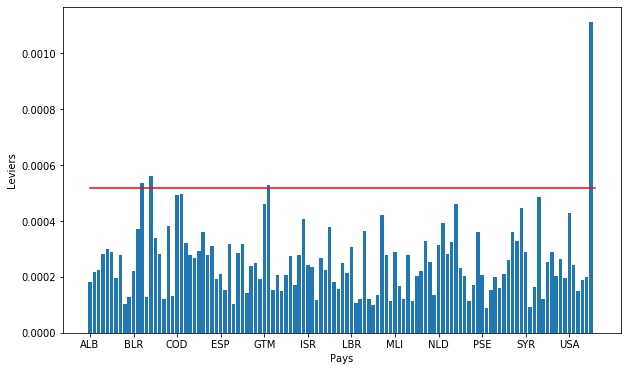

In [74]:
dataFinal_mean = dataFinal_sample.groupby("country", as_index=False)['levier'].mean()

plt.figure(figsize=(10,6))
plt.bar(dataFinal_mean['country'], dataFinal_mean['levier'])
plt.xticks(np.arange(0, 116, step = 10))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='r')
plt.show()

Il y a plusieurs pays dont le levier dépasse le seuil et donc pour lesquels les valeurs sont atypiques :

In [75]:
dataFinal_mean.loc[dataFinal_mean['levier'] > seuil_levier, :]

,country,levier
12,BRA,0.000537
14,CAF,0.000561
41,HND,0.000527
115,ZAF,0.001111


Il s'agit du Brésil, de l'Afrique du Sud, du Honduras, et la République centrafricaine.

**Calcul des résidus studentisés :**

Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de libertés :

In [76]:
dataFinal_sample['rstudent'] = reg_multi_ln.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

seuil_rstudent

1.9601685822161563

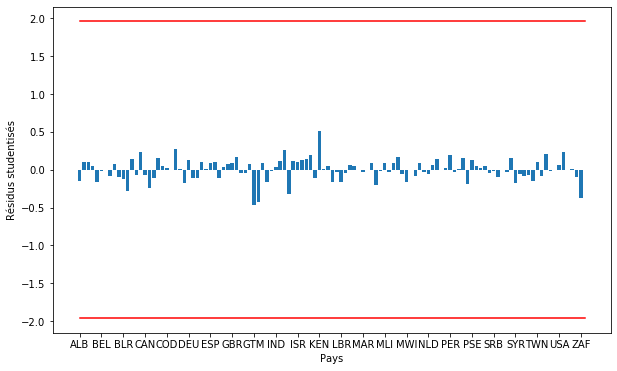

In [82]:
dataFinal_Mean_2 = dataFinal_sample.groupby('country',as_index=False)['rstudent'].mean()
#dataFinal_Mean_2 = dataFinal_sample.groupby(['country','M_j','G_j','ln_M_j','rstudent'],as_index=False).mean()

plt.figure(figsize=(10,6))
plt.bar(dataFinal_Mean_2['country'], dataFinal_Mean_2['rstudent'])
plt.xticks(np.arange(0, 116, step=5))
plt.xlabel('Pays')
plt.ylabel('Résidus studentisés')
plt.plot([0, 116], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 116], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

**Nombre de valeurs atypiques sur les variables à expliquer :**

In [83]:
residus_student = dataFinal_Mean_2.loc[(dataFinal_Mean_2['rstudent'] > seuil_rstudent) |
                             (dataFinal_Mean_2['rstudent'] < -seuil_rstudent)]

print("Il y a",len(residus_student),"valeurs atypiques.")

Il y a 0 valeurs atypiques.


**Calcul de la distance de cook :**

In [84]:
influence = reg_multi_ln.get_influence().summary_frame()
influence.head(3)

,dfb_Intercept,dfb_ln_M_j,dfb_G_j,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.004739,-0.002058,-0.005519,0.000020,0.570193,0.000181,0.007663,0.570176,0.007662
1,-0.008044,0.003494,0.009368,0.000056,-0.967843,0.000181,-0.013007,-0.967840,-0.013007
2,-0.003992,0.001734,0.004649,0.000014,-0.480358,0.000181,-0.006455,-0.480342,-0.006455


Le seuil de la distance de Cook est de n-p. 

In [85]:
dataFinal_sample['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

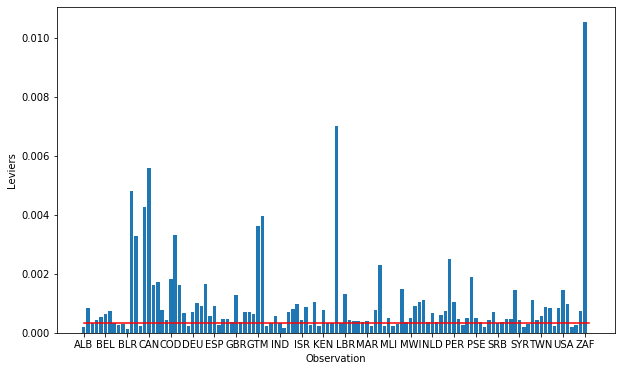

In [86]:
plt.figure(figsize=(10,6))
plt.bar(dataFinal_sample['country'], dataFinal_sample['dcooks'])
plt.xticks(np.arange(0, 116, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 116], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

**Nombre de valeurs influentes :**

In [87]:
Valeurs_influentes = dataFinal_sample.loc[dataFinal_sample['dcooks'] > seuil_dcook]
print("Il y a",len(Valeurs_influentes),"valeurs influentes.")

Il y a 640 valeurs influentes.


**Suppression des valeurs atypiques et influentes :**

In [88]:
Valeurs_atypiques_influentes = dataFinal_sample.loc[((dataFinal_sample['dcooks'] > seuil_dcook) &
                                                    (dataFinal_sample['rstudent'] > seuil_rstudent) &
                                                    (dataFinal_sample['levier'] > seuil_levier)) |
                                                    ((dataFinal_sample['dcooks'] > seuil_dcook) &
                                                    (dataFinal_sample['rstudent'] < -seuil_rstudent) &
                                                    (dataFinal_sample['levier'] > seuil_levier))]



print("Il y a",len(Valeurs_atypiques_influentes),"valeurs atypiques et influentes.")

Il y a 70 valeurs atypiques et influentes.


In [95]:
dataFinal_sample_def = pd.concat([dataFinal_sample, Valeurs_atypiques_influentes, Valeurs_atypiques_influentes]).drop_duplicates(keep=False)

dataFinal_sample_def.head(3)

,country,M_j,Année,y_child,c_i_parent,G_j,ln_y_child,ln_M_j,levier,rstudent,dcooks
0,ALB,2994.829902,2008,3998.9020,87,30.0,8.293775,8.004643,0.000181,0.570193,0.000020
1,ALB,2994.829902,2008,1325.2533,90,30.0,7.189359,8.004643,0.000181,-0.967843,0.000056
2,ALB,2994.829902,2008,1880.7145,57,30.0,7.539407,8.004643,0.000181,-0.480358,0.000014


**Nouvelle régression linéaire multiple sans les valeurs atypiques et influentes :**

In [96]:
reg_multi_ln_def = smf.ols('ln_y_child ~ ln_M_j+G_j', data=dataFinal_sample_def).fit()
print(reg_multi_ln_def.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 1.613e+04
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:44:27   Log-Likelihood:                -12111.
No. Observations:               11403   AIC:                         2.423e+04
Df Residuals:                   11400   BIC:                         2.425e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5115      0.066      7.722      0.0

**Vérification de la colinéarité des variables :**

In [97]:
variables = reg_multi_ln_def.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0971066463811556, 1.0971066463811552]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

**Test d’homoscédasticité :**

In [98]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln_def.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.139560363039985e-58


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

**Test de la normalité des résidus :**

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [99]:
shapiro(reg_multi_ln_def.resid)

(0.9767650365829468, 2.5733935453323454e-39)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

<a id="chapitre_4_3"></a>
### <span style="color: #a40334"> 3. Régression linéaire en n'incluant comme variable le revenu moyen du pays, l'indice de Gini du pays de l'individu et la classe de revenu des parents. Quel est le pourcentage de variance expliqué par ce nouveau modèle ?</span>

In [101]:
reg_multi2_0 = smf.ols('y_child ~ M_j+G_j+c_i_parent', data=dataFinal_sample).fit()
print(reg_multi2_0.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     134.5
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:47:52   Log-Likelihood:            -1.1612e+05
No. Observations:               11403   AIC:                         2.324e+05
Df Residuals:                   11301   BIC:                         2.332e+05
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2440.8079    714.72

**La p-valeur de l'indice de Gini vaut 0.276 et est supérieure au niveau de test 5%. L'indice de Gini n'est donc pas une variable significative et il ne faut pas la conserver.**

In [102]:
reg_multi2 = smf.ols('y_child ~ M_j+c_i_parent', data=dataFinal_sample).fit()
print(reg_multi2.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     135.9
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:48:11   Log-Likelihood:            -1.1612e+05
No. Observations:               11403   AIC:                         2.324e+05
Df Residuals:                   11302   BIC:                         2.332e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2802.7363    632.89

**La p-valeur de chaque classe de revenu des parents c_i_parent vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant n'est pas correlé à la classe de revenu des parents.**

**La p-valeur du revenu moyen M_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le revenu de l'enfant n'est pas correlé au revenu moyen.**

**Analyse de la variance**

In [103]:
Decomposition2 = sm.stats.anova_lm(reg_multi2, typ=2)
Decomposition2

,sum_sq,df,F,PR(>F)
c_i_parent,3.317876e+10,99.0,8.100383,6.008547e-106
M_j,5.243712e+11,1.0,12674.165988,0.000000e+00
Residual,4.676003e+11,11302.0,NaN,NaN


In [104]:
# Variance expliquée par le revenu moyen :
R2_M_j_2 = Decomposition2.sum_sq['M_j']/Decomposition2.sum_sq.sum()

# Variance expliquée par l'indice de Gini :
#R2_G_j_2 = Decomposition2.sum_sq['G_j']/Decomposition2.sum_sq.sum()

# Variance expliquée par la classe de revenu des parents :
R2_c_i_parent = Decomposition2.sum_sq['c_i_parent']/Decomposition2.sum_sq.sum()

print(round(R2_M_j_2*100,2),"% de la variance du modèle est expliquée par le revenu moyen.")
#print(round(R2_G_j_2*100,6),"% de la variance du modèle est expliquée par l'indice de Gini.")
print(round(R2_c_i_parent*100,2),"% de la variance du modèle est expliquée par la classe de revenu des parents.")
print(round((reg_multi2.rsquared-R2_M_j_2-R2_c_i_parent)*100,2),"% de la variance du modèle est expliquée par les efforts et la chance.")
#print(round((reg_multi2.rsquared-R2_M_j_2-R2_G_j_2-R2_c_i_parent)*100,2),"% de la variance du modèle est expliquée par les efforts et la chance.")
print("Le pourcentage de variance expliqué par ce modèle est de",round(reg_multi2.rsquared*100,2),"%.")

51.15 % de la variance du modèle est expliquée par le revenu moyen.
3.24 % de la variance du modèle est expliquée par la classe de revenu des parents.
0.2 % de la variance du modèle est expliquée par les efforts et la chance.
Le pourcentage de variance expliqué par ce modèle est de 54.59 %.


**Calcul avec les logarithmes du revenu moyen et des revenus de l'enfant**

In [105]:
reg_multi2_ln = smf.ols('ln_y_child ~ ln_M_j+G_j+c_i_parent', data=dataFinal_sample).fit()
print(reg_multi2_ln.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     433.3
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:49:23   Log-Likelihood:                -10737.
No. Observations:               11403   AIC:                         2.168e+04
Df Residuals:                   11301   BIC:                         2.243e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.3822      0.08

**La p-valeur de chaque classe de revenu des parents c_i_parent vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le logarithme du revenu de l'enfant n'est pas correlé à la classe de revenu des parents.**

**La p-valeur du revenu moyen M_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le logarithme du revenu de l'enfant n'est pas correlé au revenu moyen.**

**La p-valeur de l'indice de Gini G_j vaut 0 et est inférieure au niveau de test 5%. On peut rejeter l'hypothèse nulle selon laquelle le logarithme du revenu de l'enfant n'est pas correlé à l'indice de Gini.**

**Analyse de la variance**

In [106]:
Decomposition2_ln = sm.stats.anova_lm(reg_multi2_ln, typ=2)
Decomposition2_ln

,sum_sq,df,F,PR(>F)
c_i_parent,1196.092655,99.0,31.103678,0.000000e+00
ln_M_j,13135.630778,1.0,33816.841833,0.000000e+00
G_j,186.226406,1.0,479.427979,4.082948e-104
Residual,4389.699196,11301.0,NaN,NaN


In [107]:
# Variance expliquée par le revenu moyen :
ln_R2_M_j_2 = Decomposition2_ln.sum_sq['ln_M_j']/Decomposition2_ln.sum_sq.sum()

# Variance expliquée par l'indice de Gini :
ln_R2_G_j_2 = Decomposition2_ln.sum_sq['G_j']/Decomposition2_ln.sum_sq.sum()

# Variance expliquée par la classe de revenu des parents :
ln_R2_c_i_parent = Decomposition2_ln.sum_sq['c_i_parent']/Decomposition2_ln.sum_sq.sum()

print(round(ln_R2_M_j_2*100,2),"% de la variance du modèle est expliquée par le revenu moyen.")
print(round(ln_R2_G_j_2*100,6),"% de la variance du modèle est expliquée par l'indice de Gini.")
print(round(ln_R2_c_i_parent*100,2),"% de la variance du modèle est expliquée par la classe de revenu des parents.")
print(round((reg_multi2_ln.rsquared-ln_R2_M_j_2-ln_R2_G_j_2-ln_R2_c_i_parent)*100,2),"% de la variance du modèle est expliquée par les efforts et la chance.")
print("Le pourcentage de variance expliqué par ce modèle est de",round(reg_multi2_ln.rsquared*100,2),"%.")

69.47 % de la variance du modèle est expliquée par le revenu moyen.
0.984926 % de la variance du modèle est expliquée par l'indice de Gini.
6.33 % de la variance du modèle est expliquée par la classe de revenu des parents.
2.69 % de la variance du modèle est expliquée par les efforts et la chance.
Le pourcentage de variance expliqué par ce modèle est de 79.48 %.


### Analyses des résultats

**Analyse de l'atypicité des variables explicatives**

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [108]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [109]:
n = dataFinal.shape[0]
p2 = 4

**Calcul des leviers**

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [110]:
dataFinal_sample['levier2'] = reg_multi2_ln.get_influence().hat_matrix_diag

seuil_levier_2 = 2*p2/n

Points pour lesquels le levier est supérieur au seuil :

In [111]:
dataFinal_sample.loc[dataFinal_sample['levier2'] > seuil_levier_2, :]

,country,M_j,Année,y_child,c_i_parent,G_j,ln_y_child,ln_M_j,levier,rstudent,dcooks,levier2
0,ALB,2994.829902,2008,3998.9020,87,30.0,8.293775,8.004643,0.000181,0.570193,0.000020,0.009720
1,ALB,2994.829902,2008,1325.2533,90,30.0,7.189359,8.004643,0.000181,-0.967843,0.000056,0.008528
2,ALB,2994.829902,2008,1880.7145,57,30.0,7.539407,8.004643,0.000181,-0.480358,0.000014,0.009002
3,ALB,2994.829902,2008,9351.7510,69,30.0,9.143319,8.004643,0.000181,1.753287,0.000185,0.008717
4,ALB,2994.829902,2008,1669.9136,68,30.0,7.420527,8.004643,0.000181,-0.645913,0.000025,0.008379
...,...,...,...,...,...,...,...,...,...,...,...,...
11594,ZAF,5617.904880,2008,1368.0852,12,63.2,7.221167,8.633714,0.001111,-0.982169,0.000358,0.010259
11595,ZAF,5617.904880,2008,894.8605,51,63.2,6.796668,8.633714,0.001111,-1.573613,0.000918,0.009512
11596,ZAF,5617.904880,2008,7406.3980,72,63.2,8.910100,8.633714,0.001111,1.370972,0.000697,0.010031
11597,ZAF,5617.904880,2008,749.1676,42,63.2,6.618963,8.633714,0.001111,-1.821204,0.001230,0.010752


**Représentation graphique :**

Pour éviter d'avoir trop de lignes, nous allons grouper par pays afin d'identifier pour lesquels d'entre eux les variables explicatives sont atypiques, c'est-à-dire au-dessus du seuil-levier.

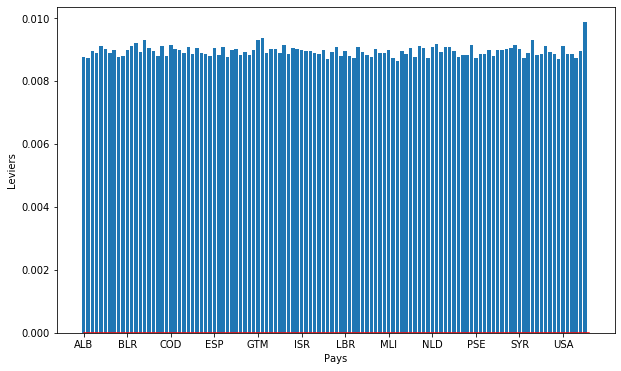

In [112]:
dataFinal_mean2 = dataFinal_sample.groupby("country", as_index=False)['levier2'].mean()

plt.figure(figsize=(10,6))
plt.bar(dataFinal_mean2['country'], dataFinal_mean2['levier2'])
plt.xticks(np.arange(0, 116, step = 10))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, 116], [seuil_levier_2, seuil_levier_2], color='r')
plt.show()

In [113]:
dataFinal_mean2.loc[dataFinal_mean2['levier2'] > seuil_levier_2, :]

,country,levier2
0,ALB,0.008773
1,ARG,0.008741
2,ARM,0.008964
3,AUT,0.008901
4,AZE,0.009102
...,...,...
111,VEN,0.008856
112,VNM,0.008853
113,XKX,0.008728
114,YEM,0.008945


**Calcul des résidus studentisés :**

Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de libertés :

In [114]:
dataFinal_sample['rstudent2'] = reg_multi2_ln.get_influence().resid_studentized_internal
seuil_rstudent2 = t.ppf(1-alpha/2,n-p2-1)

seuil_rstudent2

1.9599643935527715

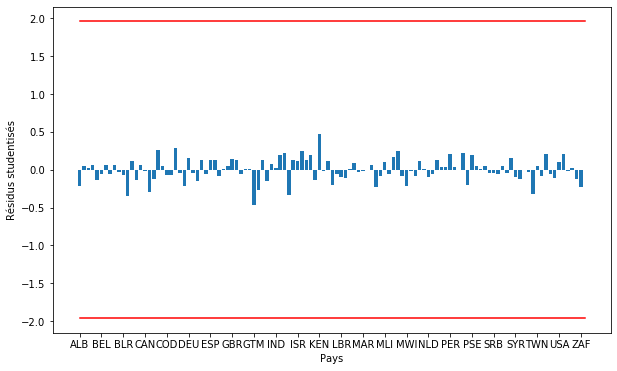

In [125]:
dataFinal_Mean_2 = dataFinal_sample.groupby("country",as_index=False)['rstudent2'].mean()

plt.figure(figsize=(10,6))
plt.bar(dataFinal_Mean_2['country'], dataFinal_Mean_2['rstudent2'])
plt.xticks(np.arange(0, 116, step=5))
plt.xlabel('Pays')
plt.ylabel('Résidus studentisés')
plt.plot([0, 116], [seuil_rstudent2, seuil_rstudent2], color='r')
plt.plot([0, 116], [-seuil_rstudent2, -seuil_rstudent2], color='r')
plt.show()

**Nombre de variables à expliquer atypiques :**

In [126]:
residus_student2 = dataFinal_Mean_2.loc[(dataFinal_Mean_2['rstudent2'] > seuil_rstudent2) |
                             (dataFinal_Mean_2['rstudent2'] < -seuil_rstudent2)]

print("Il y a",len(residus_student2),"valeurs atypiques.")

Il y a 0 valeurs atypiques.


**Détermination de la distance de Cook :**

In [127]:
influence2 = reg_multi2_ln.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. Au-delà de ce seuil, les données sont influentes.

In [128]:
dataFinal_Mean_2['dcooks2'] = influence2['cooks_d']
dataFinal_sample['dcooks2'] = influence2['cooks_d']
seuil_dcook2 = 4/(n-p2)

**Mesures atypiques et influentes :**

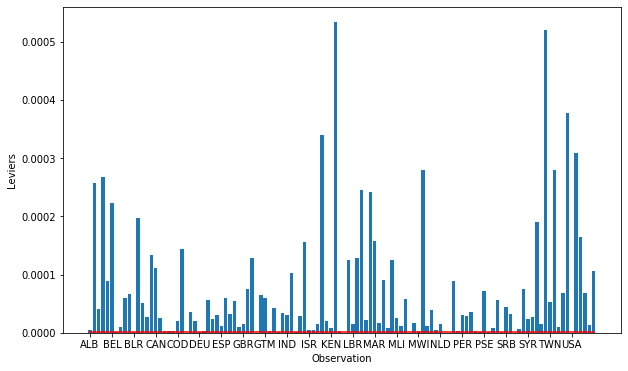

In [129]:
plt.figure(figsize=(10,6))
plt.bar(dataFinal_Mean_2['country'], dataFinal_Mean_2['dcooks2'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_dcook2, seuil_dcook2], color='r')
plt.show()

**Nombre de valeurs influentes :**

In [130]:
Valeurs_influentes2 = dataFinal_sample.loc[dataFinal_sample['dcooks2'] > seuil_dcook2]
print("Il y a",len(Valeurs_influentes2),"valeurs influentes.")

Il y a 10437 valeurs influentes.


**Suppression des valeurs atypiques et influentes :**

In [135]:
Valeurs_atypiques_influentes2 = dataFinal_sample.loc[((dataFinal_sample['dcooks2'] > seuil_dcook2) &
                                                     (dataFinal_sample['rstudent'] > seuil_rstudent2) &
                                                     (dataFinal_sample['levier2'] > seuil_levier_2)) |
                                                     ((dataFinal_sample['dcooks2'] > seuil_dcook2) &
                                                     (dataFinal_sample['rstudent2'] < -seuil_rstudent2) &
                                                     (dataFinal_sample['levier2'] > seuil_levier_2))]



print("Il y a",len(Valeurs_atypiques_influentes2),"valeurs atypiques et influentes.")

Il y a 538 valeurs atypiques et influentes.


In [139]:
dataFinal_sample_def2 = pd.concat([dataFinal_sample, Valeurs_atypiques_influentes2, Valeurs_atypiques_influentes2]).drop_duplicates(keep=False)

dataFinal_sample_def2.head(3)

,country,M_j,Année,y_child,c_i_parent,G_j,ln_y_child,ln_M_j,levier,rstudent,dcooks,levier2,rstudent2,dcooks2
0,ALB,2994.829902,2008,3998.9020,87,30.0,8.293775,8.004643,0.000181,0.570193,0.000020,0.009720,0.222884,0.000005
1,ALB,2994.829902,2008,1325.2533,90,30.0,7.189359,8.004643,0.000181,-0.967843,0.000056,0.008528,-1.746463,0.000257
2,ALB,2994.829902,2008,1880.7145,57,30.0,7.539407,8.004643,0.000181,-0.480358,0.000014,0.009002,-0.673281,0.000040


**Nouvelle régression linéaire multiple sans les valeurs atypiques et influentes :**

In [140]:
reg_multi2_ln_def = smf.ols('ln_y_child ~ ln_M_j+G_j+c_i_parent', data=dataFinal_sample_def2).fit()
print(reg_multi2_ln_def.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     608.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:46:19   Log-Likelihood:                -8175.8
No. Observations:               10865   AIC:                         1.656e+04
Df Residuals:                   10763   BIC:                         1.730e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.3824      0.07

**Vérification de la colinéarité des variables :**

In [141]:
variables2 = reg_multi2_ln_def.model.exog
[variance_inflation_factor(variables2, i) for i in np.arange(1,variables2.shape[1])]

[2.1426104340039522,
 1.9926587393130808,
 2.0331155941643235,
 2.2024893704628004,
 2.332431413752463,
 2.163110947278058,
 2.1031565217064676,
 2.103269617304892,
 1.942428772286784,
 1.9329041723010603,
 2.1026550155819375,
 1.9019257706163708,
 2.2525927621830517,
 2.0631526648890697,
 2.083027891958468,
 1.861789198188264,
 2.0325003917995885,
 1.9922420827284546,
 1.972348945991285,
 2.2426989997711497,
 2.082488488980609,
 2.032878750463082,
 2.1931934570069336,
 2.072618455208271,
 2.1225527781933042,
 2.092404173112858,
 2.3124058563666408,
 2.082527109887183,
 2.052431864923525,
 2.08240230838923,
 1.9421636353713185,
 2.2324268518971824,
 2.132526740858696,
 2.2327470202335706,
 2.1626802642646625,
 1.9629100251191147,
 2.4118323648697224,
 2.1527968293392132,
 2.172540479723055,
 2.052724031838068,
 2.012694806475685,
 2.1024141781521144,
 1.9928214091670815,
 1.993315212720895,
 2.193266232112559,
 2.1130052786931106,
 2.123424373083379,
 2.342466064841908,
 2.223322300003

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

**Test d’homoscédasticité :**

In [143]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi2_ln_def.resid, variables2)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 2.7730828179470748e-33


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

**Test de la normalité des résidus :**

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [144]:
shapiro(reg_multi2_ln_def.resid)

(0.997047483921051, 6.644908419079637e-14)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

### Peut-on affirmer que le fait de vivre dans un pays inégalitaire favorise plus de personnes qu'il n'en défavorise ? (Question à traiter)